# Imports

In [207]:
import pandas as pd
import numpy as np
import nltk
import os
import textract
import spacy
import re
import string
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 150)
pd.set_option("display.precision", 3)
from itertools import cycle
from collections import defaultdict
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("words")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
from textblob import TextBlob, Word
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from corextopic import corextopic, vis_topic

# Table of Contents

1. [Goal and Context](#goal)
2. [Importing & Manipulating Data](#data)
3. [Text Pre-Processing](#preproc)
4. [Topic Modeling](#topicmodel)
5. [Visualization: pyLDAvis](#ldavis)
6. [Clustering](#kmeans)
7. [Visualization: PCA](#pca)
8. [Visualization: t-SNE](#tsne)
9. [Takeaways & Implications](#conc)
10. [CorEx](#corex)


# Goal and Context <a class="anchor" id="goal"></a>

The development of Artificial Intelligence brings renewed interest to an ages old question -- the nature of consciousness. In answering the 'hard' problem of consciousness, the western world and neuroscience leans pretty heavily toward physical monism -- that mind is simply derived from brain, no more.

However, the 20th century breakthroughs in quantum mechanics created a paradigm shift in how we concieve of reality and, indeed, consciousness. I wanted to investigate whether these quantum metaphysical implications of consciousness could be correlated to descriptions of the same as found in Eastern religion and philosphy.

I believe that a convergence of those descriptions could provide new insight and a direction of future investigation, and that Machine Learning can be used to find these correlations.

# Loading In DataFrame <a class="anchor" id="data"></a>

In [4]:
f = open("df.data", "rb")
df = pickle.load(f)
f.close()
df

,Title,Genre,Text
0,The Abhidhamma In Practice,Buddhism,Preface \nThis book is not a synopsis of the ...
1,Brahma Sutras,Hinduism,INTRODUCTION.\n\nIn the Introduction to the fi...
2,The Finer Scale of Consciousness: Quantum Theory,Quantum,The finer scale of consciousness: quantum theo...
3,Mind and Consciousness in Yoga - Vedanta: A Co...,Hinduism,Mind and consciousness in yoga – Vedanta: A co...
4,A Comprehensive Manual of Abhidhamma,Buddhism,INTRODUCTION\n\n1\n\nINTRODUCTION\n\nThe nucle...
5,Brahma Sutras: Commentary by Sri Swami Sivananda,Hinduism,SYNOPSIS\n\nThis sec tion gives a bird’s-eye v...
6,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...
7,"Consciousness, Mind and Matter in Indian Philo...",Hinduism,Journal of Consciousness Exploration & Researc...
8,Information-Consciousness-Reality,Quantum,Chapter 1\nIntroduction\n\nThis is a story abo...
9,Process of Consciousness and Matter,Buddhism,\n\nINTRODUCTION \n\n \nThis book is intended...


# Making the Documents Paragraphs 
TLDR; I am going to divide the books up so each row of my dataframe is a paragraph. 

Right now, each document (or, row in the dataframe) is an entire article or book,several hundred pages long. Ultimately, I want simply to compare eastern philosophical takes on consciousness vs. quantum ones. I can have as many examples of each as I want -- it isn't the individual documents that matter, but the designations of documents as either 'religion' or 'quantum'. It will be more meaningful to find the most common sentiments and associated words to consciousness wihin each parapgraph, than within the entire book (which will have tons and tons of features etc.)

Checking out paragraph splitting syntax for each doc (just pulling them up one at a time to inspect using the syntax below), it looks like they all split paragraphs on "\n\n" character. 

### Quick Cleaning
First though, I need to deal with the weird formatting in this one document:

In [5]:
df["Text"][13][0:1000]

'Journal\xa0of\xa0Cosmology,\xa02009,\xa0Vol\xa03,\xa0pages\xa0500‐510.\xa0\n\nThe\xa0Universe,\xa0Quantum\xa0Physics,\xa0and\xa0\n\nConsciousness\xa0\xa0\n\nSubhash\xa0Kak\xa0\n\nIntroduction\xa0\n\xa0\nThere\xa0are\xa0two\xa0essential\xa0parts\xa0to\xa0understanding\xa0the\xa0universe:\xa0its\xa0representation\xa0in\xa0terms\xa0of\xa0material\xa0objects,\xa0and\xa0the\xa0manner\xa0in\xa0\nwhich\xa0this\xa0representation\xa0changes\xa0with\xa0time.\xa0In\xa0philosophy,\xa0these\xa0are\xa0the\xa0positions\xa0of\xa0two\xa0different\xa0schools,\xa0one\xa0believing\xa0that\xa0\nreality\xa0is\xa0being,\xa0and\xa0the\xa0other\xa0that\xa0it\xa0is\xa0becoming.\xa0\xa0\n\xa0\nThe\xa0conception\xa0of\xa0the\xa0cosmos,\xa0consisting\xa0of\xa0the\xa0material\xa0universe\xa0and\xa0observers,\xa0has\xa0been\xa0shaped\xa0by\xa0ideas\xa0that\xa0belong\xa0to\xa0these\xa0\ntwo\xa0opposite\xa0schools.\xa0The\xa0conception\xa0of\xa0the\xa0world\xa0as\xa0being\xa0is\xa0associated\xa0with\xa0materialism,\x

In [6]:
df["Text"][13] = re.sub("\xa0", " ", df["Text"][13])

In [7]:
df["Text"][13][0:1000]

'Journal of Cosmology, 2009, Vol 3, pages 500‐510. \n\nThe Universe, Quantum Physics, and \n\nConsciousness  \n\nSubhash Kak \n\nIntroduction \n \nThere are two essential parts to understanding the universe: its representation in terms of material objects, and the manner in \nwhich this representation changes with time. In philosophy, these are the positions of two different schools, one believing that \nreality is being, and the other that it is becoming.  \n \nThe conception of the cosmos, consisting of the material universe and observers, has been shaped by ideas that belong to these \ntwo opposite schools. The conception of the world as being is associated with materialism, while that of becoming is associated \nwith  idealism.  In  the  materialist  view,  mental  experience  is  emergent  on  the  material  ground  and  contents of  the  mind  are \nsecondary to the physical world. Conversely, in the idealist position consciousness has primacy.  \n \nThe question of consciousness

Better! All the other documents look normal. Now, moving on with splitting on paragraphs:

In [8]:
split_paragraphs = lambda x: x.split("\n\n")

In [10]:
df["Paragraphs"] = df["Text"].map(split_paragraphs)
df

,Title,Genre,Text,Paragraphs
0,The Abhidhamma In Practice,Buddhism,Preface \nThis book is not a synopsis of the ...,[Preface \nThis book is not a synopsis of the...
1,Brahma Sutras,Hinduism,INTRODUCTION.\n\nIn the Introduction to the fi...,"[INTRODUCTION., In the Introduction to the fir..."
2,The Finer Scale of Consciousness: Quantum Theory,Quantum,The finer scale of consciousness: quantum theo...,[The finer scale of consciousness: quantum the...
3,Mind and Consciousness in Yoga - Vedanta: A Co...,Hinduism,Mind and consciousness in yoga – Vedanta: A co...,[Mind and consciousness in yoga – Vedanta: A c...
4,A Comprehensive Manual of Abhidhamma,Buddhism,INTRODUCTION\n\n1\n\nINTRODUCTION\n\nThe nucle...,"[INTRODUCTION, 1, INTRODUCTION, The nucleus of..."
5,Brahma Sutras: Commentary by Sri Swami Sivananda,Hinduism,SYNOPSIS\n\nThis sec tion gives a bird’s-eye v...,"[SYNOPSIS, This sec tion gives a bird’s-eye vi..."
6,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...,"[Rig Veda – English Translation , , , , RIG..."
7,"Consciousness, Mind and Matter in Indian Philo...",Hinduism,Journal of Consciousness Exploration & Researc...,[Journal of Consciousness Exploration & Resear...
8,Information-Consciousness-Reality,Quantum,Chapter 1\nIntroduction\n\nThis is a story abo...,"[Chapter 1\nIntroduction, This is a story abou..."
9,Process of Consciousness and Matter,Buddhism,\n\nINTRODUCTION \n\n \nThis book is intended...,"[ , INTRODUCTION , \nThis book is intended fo..."


In [11]:
df = df["Paragraphs"].apply(pd.Series).merge(df, left_index=True, right_index=True)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,10716,10717,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735,10736,Title,Genre,Text,Paragraphs
0,Preface \nThis book is not a synopsis of the ...,The writer wishes to place on record:,The inspiration gained from Dhamma discussions...,Homage to the Supremely Enlightened One\nHomag...,The Abhidhamma forms the third part of the Pal...,Origins\nTheravaada tradition holds that the B...,From ancient times doubts have been expressed ...,The question is also raised whether the Abhidh...,The Ultimate Realities\nThe Abhidhamma deals w...,"Citta, mind or consciousness, defined as that ...","Citta, cetasikas, and nibbaana are also called...",The Cittas \nAwareness is the process of citt...,The Arising of the Cittas\nCittas are classifi...,Cittas which are resultant states of conscious...,To be aware of the momentariness of this vipaa...,When the mind is not experiencing objects thro...,Cittas exhibit certain other interesting featu...,"Association with ""roots."" Cittas may be associ...",There are six roots. Three are kammically unwh...,In the ordinary unenlightened worldling these ...,For spiritual progress it is important to be a...,Association with feeling. Cittas differ accord...,It is important to recognize the feeling that ...,Prompted and unprompted cittas. A prompted cit...,If the prompted citta is a wholesome one resul...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Abhidhamma In Practice,Buddhism,Preface \nThis book is not a synopsis of the ...,[Preface \nThis book is not a synopsis of the...
1,INTRODUCTION.,In the Introduction to the first volume of the...,The question as to what the St�ras really teac...,The question as to the true meaning of the S�t...,The present translation of the Sr�bh�shya clai...,It gives me great pleasure to acknowledge the ...,,\nVED�NTA-S�TRAS,WITH,R�M�NUJA'S SR�BH�SHYA,FIRST ADHY�YA.,FIRST P�DA.,MAY my mind be filled with devotion towards th...,The nectar of the teaching of Par�sara's son (...,The lengthy explanation (vritti) of the Brahma...,,\n1. Then therefore the enquiry into Brahman.,In this S�tra the word 'then' expresses immedi...,The compound 'brahmajij��s�' is to be explaine...,The word 'Brahman' denotes the hightest Person...,From all these it is understood that the study...,And this study of the Veda is of the nature of...,The injunction as to the study of the Veda thu...,It is further observed that the Veda thus appr...,But--an objection here is raised--the mere lea...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brahma Sutras,Hinduism,INTRODUCTION.\n\nIn the Introduction to the fi...,"[INTRODUCTION., In the Introduction to the fir..."
2,The finer scale of consciousness: quantum theory,Consciousness is a multidisciplinary problem t...,"Introduction\nThe nature of consciousness, onc...",Origination\nConsciousness was brought onto th...,"\nInitial exploration\nIn the 1930s, the Hunga...",\nGradual systematization\nMany biological sci...,\nSchematic diagram of dendrons and psychons o...,Following the analogy of probabilistic fields ...,"However, after more than twenty years, no subs...",\nIt was widely accepted that most neuronal co...,"To date, this theory has remained one of the m...",Under the background of rapid development of w...,\nConceptual graph of quantum space-time struc...,"Originally, the cytoskeleton was proposed as t...","Microtubules and tubulins, as the elaborate an...",Neurons with gap junctions and microtubules. L...,Tubulins were deconstructed long ago. The stud...,Similar to the initiation of information trans...,\nOrch-OR event. Minor tubulins begin with cla...,"However, debates have become increasingly turb...",Conclusion and perspective\nQuantum mechanics ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [12]:
df = df.melt(id_vars = ["Title", "Genre", "Text", "Paragraphs"], value_name = "Paragraph Text")
df.dropna(inplace=True)
df

,Title,Genre,Text,Paragraphs,variable,Paragraph Text
0,The Abhidhamma In Practice,Buddhism,Preface \nThis book is not a synopsis of the ...,[Preface \nThis book is not a synopsis of the...,0,Preface \nThis book is not a synopsis of the ...
1,Brahma Sutras,Hinduism,INTRODUCTION.\n\nIn the Introduction to the fi...,"[INTRODUCTION., In the Introduction to the fir...",0,INTRODUCTION.
2,The Finer Scale of Consciousness: Quantum Theory,Quantum,The finer scale of consciousness: quantum theo...,[The finer scale of consciousness: quantum the...,0,The finer scale of consciousness: quantum theory
3,Mind and Consciousness in Yoga - Vedanta: A Co...,Hinduism,Mind and consciousness in yoga – Vedanta: A co...,[Mind and consciousness in yoga – Vedanta: A c...,0,Mind and consciousness in yoga – Vedanta: A co...
4,A Comprehensive Manual of Abhidhamma,Buddhism,INTRODUCTION\n\n1\n\nINTRODUCTION\n\nThe nucle...,"[INTRODUCTION, 1, INTRODUCTION, The nucleus of...",0,INTRODUCTION
...,...,...,...,...,...,...
182450,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...,"[Rig Veda – English Translation , , , , RIG...",10732,"IX, 1. Hymn to the honey-lash of the Asvins."
182467,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...,"[Rig Veda – English Translation , , , , RIG...",10733,"1. From heaven, from earth, from the atmospher..."
182484,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...,"[Rig Veda – English Translation , , , , RIG...",10734,
182501,The Four Vedas,Hinduism,Rig Veda – English Translation \n\n \n\n \n\n ...,"[Rig Veda – English Translation , , , , RIG...",10735,1444


In [13]:
df = df[["Title", "Genre", "Paragraph Text"]]
df.sort_values(["Title"], inplace=True)
df

,Title,Genre,Paragraph Text
36309,108 Upanishads,Hinduism,Within the Lotus of the Heart
16691,108 Upanishads,Hinduism,"In fear of him fire burns, the sun shines, the..."
62370,108 Upanishads,Hinduism,One who is the soul; 3.11
16674,108 Upanishads,Hinduism,Brahman is Inexorable Power as well as Infinit...
62387,108 Upanishads,Hinduism,One who is soul of the inner consciousness; 3.12
...,...,...,...
8346,The Yoga Sutras of Patanjali,Hinduism,"True knowledge of the ""mind"" comes, first, whe..."
492,The Yoga Sutras of Patanjali,Hinduism,8. Unsound intellection is false understanding...
4283,The Yoga Sutras of Patanjali,Hinduism,51. The fourth degree transcends external and ...
1614,The Yoga Sutras of Patanjali,Hinduism,"For the Eastern sages, dreams are, it is true,..."


# Text Pre-processing <a class="anchor" id="preproc"></a>
For my initial pre-processing steps I am removing punctuation, numbers, stop words, non-english words, making everything lowercase, and lemmatizing. 

Additional pre-processing (removal of more stop words etc.) will be necessary in the iterative process of improving the topic modeling performance, but this first pass makes topic modeling possible. 

## Text Cleaning


In [19]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [20]:
df["Paragraph Text"] = df["Paragraph Text"].map(breaks).map(alphanumeric).map(punc_lower)

In [21]:
df.reset_index(inplace=True)
del df["index"]
df

,Title,Genre,Paragraph Text
0,108 Upanishads,Hinduism,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire burns the sun shines the r...
2,108 Upanishads,Hinduism,one who is the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness
...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding n...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree transcends external and int...
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern sages dreams are it is true ma...


In [218]:
df

,Title,Genre,Paragraph Text,Lemmatized
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness
...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...


### Pickling Clean DataFrame for Safety

In [219]:
f = open("clean_df.data", "wb")
pickle.dump(df, f)
f.close()

## Removing Non-English Words
Since my texts come from several cultures, they often contain a great deal of Sanskrit and Pali words -- as headings of chapters for instance, referencing the primary source material before offering translations/interpretations -- ultimately the interpretations are what I care about, so I'm just removing the non-English parts. 

In [516]:
# a list of all english words known to nltk
words = set(nltk.corpus.words.words())
len(words)

235892

In [17]:
words = [word.lower() for word in words]

Checking if a few key non-english words that I want to keep are in the words corpus (and they are! great!)

In [18]:
for word in ["atman", "brahman", "brahma", "sutra", "tao"]:
    print(word in words)

True
True
True
True
True


In [23]:
delete_non_english = lambda x: " ".join(w for w in nltk.word_tokenize(x) if w in words)

In [24]:
df["Paragraph Text"] = df["Paragraph Text"].apply(delete_non_english)

In [25]:
df

,Title,Genre,Paragraph Text
0,108 Upanishads,Hinduism,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...
2,108 Upanishads,Hinduism,one who is the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness
...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...


## Defining Stop-Words

In [518]:
for text in df["Paragraph Text"][0:20]:
    print(text)

within the lotus of the heart
in fear of him fire the sun the fall the blow and death katha
one who is the soul
brahman is inexorable power as well as infinite consciousness his presence is like the thunderbolt whose light us to all lesser whose creative sound is om expanding through the the ether of consciousness in which all of which they consist those who unite with this brahman experience their eternal immortality and become fearless especially in the face of the mirage death the divine will
one who is soul of the inner consciousness
awful is outdated english awesome is much more correct in older of english awful horrible and terrible all meant awesome and were positive but at this point in time they have reversed polarity and become negative
one who is god of death
the whole universe came forth from brahman and in brahman mighty and awful is he like to a thunderbolt loud through the heavens for those who attain him death no terror
one who is the destroyer
one who is the death
sinc

Random sample of text above looking pretty clean! Now removing words with very little semantic value.

In [27]:
my_stop_words = stopwords.words("english")
print(my_stop_words)
type(my_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

list

I want to keep words relating to "self" because my whole project is about the ideation of self! So I'm removing those from the default stop_words list.

In [28]:
words_to_keep = ["yourself", "yourselves", "myself", "himself", "herself", "ourselves", "themselves"]
for word in words_to_keep:
    my_stop_words.remove(word)

## Vectorization 
Going to run a simple count vectorizer to look at my features. 

In [29]:
cv = CountVectorizer(stop_words=my_stop_words)
doc_word = cv.fit_transform(df["Paragraph Text"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,aaron,ab,abacus,abandon,abandoned,abandonment,abbreviation,abdat,abdomen,abduction,aberrant,aberration,abhor,abhorrence,abhorrent,abide,abider,abiding,ability,abject,ablative,ablaze,able,...,yourself,yourselves,youth,youthful,youthfulness,yuga,yule,za,zak,zeal,zealous,zealously,zen,zenith,zer,zero,zest,zeta,zodiac,zombie,zone,zoo,zoology,zoom,zygote
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Lemmatization
Over 18000 unique words after vectorization is a ton, and even in just the first few columns you see "abandon", "abandoned", "abandonment", which is redundent. I'm going to lemmatize to combine conjugations of the same word to reduce total features. 

In [30]:
lemmatizer = WordNetLemmatizer()
word_tokenizer = lambda x: word_tokenize(x)
lemmatize = lambda x: " ".join([lemmatizer.lemmatize(w) for w in x])

In [31]:
df["Lemmatized"] = df["Paragraph Text"].apply(word_tokenizer).apply(lemmatize)
df

,Title,Genre,Paragraph Text,Lemmatized
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of him fire the sun the fall the blow ...
2,108 Upanishads,Hinduism,one who is the soul,one who is the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman is inexorable power a well a infinite ...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who is soul of the inner consciousness
...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection is false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern are it is true made up of of w...


In [47]:
cv = CountVectorizer(stop_words=my_stop_words)
doc_word = cv.fit_transform(df["Lemmatized"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,aaron,ab,abacus,abandon,abandonment,abbreviation,abdat,abdoman,abdomen,abduction,aberrant,aberration,abhor,abhorrence,abhorrent,abide,abider,abiding,ability,abject,ablative,ablaze,able,...,youngling,yourself,youth,youthful,youthfulness,yuga,yule,za,zak,zeal,zealous,zealously,zen,zenith,zer,zero,zest,zeta,zodiac,zombie,zone,zoo,zoology,zoom,zygote
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


That didn't do a very good job. Checking manually: 

In [33]:
print(lemmatizer.lemmatize("abandonment"))
print(lemmatizer.lemmatize("abandoned"))

abandonment
abandoned


Hmm. Well that's not very effective. Perhaps I'll now try stemming on top:

In [34]:
stemmer = PorterStemmer()
word_tokenizer = lambda x: word_tokenize(x)
stem = lambda x: " ".join([stemmer.stem(w) for w in x])

In [48]:
df["Stemmed"] = df["Lemmatized"].apply(word_tokenizer).apply(stem)
df

,Title,Genre,Paragraph Text,Lemmatized,Stemmed
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart,within the lotu of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...,in fear of -pron- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...,brahman be inexor power as well as infinit con...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness,one who be soul of the inner conscious
...,...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...,true knowledg of the mind come first when the ...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...,unsound intellect be fals understand not rest ...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal,the fourth degre extern and intern
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...,for the eastern be -pron- be true make up of o...


In [49]:
cv = CountVectorizer(stop_words=my_stop_words)
doc_word = cv.fit_transform(df["Stemmed"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,aaron,ab,abacu,abandon,abbrevi,abdat,abdoman,abdomen,abduct,aberr,abhor,abhorr,abid,abil,abject,abl,ablaz,abli,ablut,abneg,abner,abnorm,abod,...,young,younger,youngl,yourself,youth,yuga,yule,za,zak,zeal,zealou,zealous,zen,zenith,zer,zero,zest,zeta,zodiac,zombi,zone,zoo,zoolog,zoom,zygot
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Too aggressive. Yeah it got rid of the abandoned/abandonment duplicates but it also reduced important words like "spiritual" to nonsense like "spiritu" which is nonsense. And Porter is already the least aggressive stemmer. I'm not going to use stemming.

In [50]:
df

,Title,Genre,Paragraph Text,Lemmatized,Stemmed
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart,within the lotu of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...,in fear of -pron- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...,brahman be inexor power as well as infinit con...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness,one who be soul of the inner conscious
...,...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...,true knowledg of the mind come first when the ...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...,unsound intellect be fals understand not rest ...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal,the fourth degre extern and intern
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...,for the eastern be -pron- be true make up of o...


In [51]:
del df["Stemmed"]

Looks like instead I can pass parts of speech to improve lemmatizer performance.

In [52]:
print(nltk.pos_tag(["abandoned"]))

[('abandoned', 'VBN')]


In [53]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [54]:
lemmatizer = WordNetLemmatizer()
word = "abandoned"
word2 = "abandonment"
word3 = "yourselves"
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
print(lemmatizer.lemmatize(word2, get_wordnet_pos(word2)))
print(lemmatizer.lemmatize(word3, get_wordnet_pos(word3)))

abandon
abandonment
yourselves


I mean yeah it's a little better... let's try SpaCy

In [55]:
nlp = spacy.load("en", disable=["parser", "ner"])
doc = nlp("abandoned, abandonment, yourselves")
" ".join([token.lemma_ for token in doc])

'abandon , abandonment , yourself'

Better! I'll use it. (Note I tried the TextBlob lemmatizer earlier too but deleted it because it was exactly the same as the WordNetLemmatizer)

In [56]:
nlp = spacy.load("en", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [57]:
df["Lemmatized"] = df["Paragraph Text"].apply(spacy_lemmatize)
df

,Title,Genre,Paragraph Text,Lemmatized
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness
...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...


In [58]:
cv = CountVectorizer(stop_words=my_stop_words)
doc_word = cv.fit_transform(df["Lemmatized"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,aaron,ab,abacus,abandon,abandonment,abbreviation,abdat,abdoman,abdomen,abduction,aberrant,aberration,abhor,abhorrence,abhorrent,abide,abider,abiding,ability,abject,ablative,ablaze,able,...,youngling,yourself,youth,youthful,youthfulness,yuga,yule,za,zak,zeal,zealous,zealously,zen,zenith,zer,zero,zest,zeta,zodiac,zombie,zone,zoo,zoology,zoom,zygote
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So in all, it deleted about 500 more words by combing with their stems. I'll take that improvement.

In [169]:
df

,Title,Genre,Paragraph Text,Lemmatized
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness
...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...


In [2]:
f = open("clean_df.data", "rb")
df = pickle.load(f)
f.close()
df

,Title,Genre,Paragraph Text,Lemmatized
0,108 Upanishads,Hinduism,within the lotus of the heart,within the lotus of the heart
1,108 Upanishads,Hinduism,in fear of him fire the sun the fall the blow ...,in fear of -PRON- fire the sun the fall the bl...
2,108 Upanishads,Hinduism,one who is the soul,one who be the soul
3,108 Upanishads,Hinduism,brahman is inexorable power as well as infinit...,brahman be inexorable power as well as infinit...
4,108 Upanishads,Hinduism,one who is soul of the inner consciousness,one who be soul of the inner consciousness
...,...,...,...,...
44969,The Yoga Sutras of Patanjali,Hinduism,true knowledge of the mind comes first when th...,true knowledge of the mind come first when the...
44970,The Yoga Sutras of Patanjali,Hinduism,unsound intellection is false understanding no...,unsound intellection be false understanding no...
44971,The Yoga Sutras of Patanjali,Hinduism,the fourth degree external and internal,the fourth degree external and internal
44972,The Yoga Sutras of Patanjali,Hinduism,for the eastern are it is true made up of of w...,for the eastern be -PRON- be true make up of o...


# Topic Modeling Pipeline <a class="anchor" id="topicmodel"></a>
Defining a pipeline of functions so I can make quick changes to the vectorizer, model, stop-words, and data, and look at the resultant topics until I am happy with them. 

### Defining Stop-Words

In [3]:
my_stop_words = stopwords.words("english")
print(my_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

I want to keep words relating to "self" because my whole project is about the ideation of self. Removing these from the default list of stop words: 

In [4]:
words_to_keep = ["yourself", "yourselves", "myself", "himself", "herself", "ourselves", "themselves"]
for word in words_to_keep:
    my_stop_words.remove(word)
print(my_stop_words)

['i', 'me', 'my', 'we', 'our', 'ours', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'he', 'him', 'his', 'she', "she's", 'her', 'hers', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",

### Defining Topic Modeling Class

In [243]:
class topic_model():

    def __init__(self, data, vectorizer, model, num_topics):
        self.data = data
        self.vectorizer = vectorizer
        self.model = model
        self.num_topics = num_topics 


    def vectorize(self):
        if self.vectorizer == "cv":
            if self.model == "corex":
                vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3), binary=True)
            else:
                vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3))
        elif self.vectorizer == "tfidf":
            vec = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 3))
        else: print("Please define a valid vectorizer.")

        self.doc_word = vec.fit_transform(self.data)
        self.feature_names = vec.get_feature_names()
        self.words = list(np.asarray(vec.get_feature_names()))
        self.corpus = matutils.Sparse2Corpus(self.doc_word.transpose())
        self.id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    

    def display_topics(self):
        if self.model == "lda":
            model = models.LdaModel(corpus=self.corpus, num_topics=self.num_topics, id2word=self.id2word, passes=5, random_state=42)
            topics = model.print_topics()
            print(topics)

        elif self.model == "corex":
            model = corextopic.Corex(n_hidden=self.num_topics, words=self.words, seed=1, max_iter=200)
            model.fit(self.doc_word, words=self.words, docs=self.data)
            topics = model.get_topics()
            print(topics)
            for n,topic in enumerate(topics):
                topic_words,_ = zip(*topic)
            print('{}: '.format(n) + ','.join(topic_words))

        else:
            if self.model == "lsa":
                model = TruncatedSVD(self.num_topics)
            elif self.model == "nmf":
                model = NMF(self.num_topics)
            else: print("Please define a valid model.")

            doc_topic = model.fit_transform(self.doc_word)
            for ix, topic in enumerate(model.components_):
                print("\nTopic ", ix)
                print(", ".join([self.feature_names[i] for i in topic.argsort()[:-21:-1]]))

### Defining Pipeline

In [183]:
def pipeline(data, vectorizer, model, num_topics):
    x = topic_model(data, vectorizer, model, num_topics)
    x.vectorize()
    x.display_topics()

# Topic Modeling
## OOP Pipeline Approach 
First running iterations of just LSA with CountVectorizer since its the quickest/simplest, to get an initial feel for topics and filter out more stop words. 

### Defining Data: 

In [5]:
data = df["Lemmatized"]

## LSA: 

In [186]:
pipeline(data, "cv", "lsa", 10)

working!

Topic  0
pron, pron pron, one, may, verily, thou, brahman, man, self, indra, say, verily pron, thee, world, sacrifice

Topic  1
brahman, self, one, knowledge, nature, know, body, world, soul, high, say, state, also, mind, different

Topic  2
thou, brahman, thee, self, may, thy, one, indra, art, like, man, knowledge, thou art, high, nature

Topic  3
thou, verily, pron pron, verily pron, art, thee, thou art, self, brahman, thy, one, sacrifice, world, verily pron pron, pron verily

Topic  4
one, mind, like, shall, become, without, consciousness, say, three, two, state, time, know, pron one, life

Topic  5
may, brahman, verily, one, verily pron, may pron, om, let, peace, sacrifice, art, let peace, thou art, pron may, thou

Topic  6
self, one, may, man, body, verily, high, may pron, high self, self pron, verily pron, pron self, within, soul, pron pron

Topic  7
indra, brahman, ye, one, verily, soma, verily pron, come, man, like, drink, mighty, high, hath, juice

Topic  8
brahman, 

The common word "pron" is just what the lemmatizer replaces any pronouns with. It is not important. Removing it and other fluff words. 

In [7]:
words_to_add = ["pron", "ye", "may", "let", "like", "thou", "say", "thee", "thy", "shall", "come", "verily", "hath", "hither", "would", "let"]
my_stop_words.extend(words_to_add)

In [192]:
pipeline(data, "cv", "lsa", 10)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body

Topic  2
one, mind, consciousness, become, without, state, om, three, quantum, atman

Topic  3
brahman, knowledge, nature, indra, world, effect, soma, meditation, knowledge brahman, sacrifice

Topic  4
one, brahman, self, indra, soma, high, om, bliss, high self, drink

Topic  5
indra, consciousness, quantum, object, self, nature, knowledge, soma, theory, mind

Topic  6
sacrifice, hail, mind, body, fire, go, become, world, earth, self

Topic  7
hail, hail hail, hail hail hail, one, soul, cause, thing, effect, different, knowledge

Topic  8
world, sacrifice, one, effect, two, therefore, different, thing, make, soul

Topic  9
soul, om, body, state, head, establish, quantum, establish head, individual, head om


I'd like to see more than the 10 most important words -- changed class to allow for 20. 

In [194]:
pipeline(data, "cv", "lsa", 10)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind, high, thus, become, also, soul, indra, state, make, cause, without

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body, ie, high self, meditation, also, state, view, cause, individual soul, bliss, object

Topic  2
one, mind, consciousness, become, without, state, om, three, quantum, atman, two, know, speech, time, process, vital, object, fire, four, see

Topic  3
brahman, knowledge, nature, indra, world, effect, meditation, soma, knowledge brahman, sacrifice, without, true, power, object, nescience, view, work, art, atman, way

Topic  4
one, brahman, self, indra, soma, high, bliss, om, high self, drink, supreme, hail, juice, dear, meditate, sake, mighty, head, breath, art

Topic  5
indra, consciousness, quantum, self, object, nature, knowledge, soma, mind, theory, process, time, brain, state, reality, mental, information, different, juice, drink

Topic  6
man, one, indra

In [8]:
words_to_add = ["thus", "also", "ie", "ing", "de", "con", "di", "ex", "tra", "per", "en", "three", "four"]
my_stop_words.extend(words_to_add)

In [196]:
pipeline(data, "cv", "lsa", 10)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind, high, become, indra, soul, state, make, cause, without, two, form

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body, high self, meditation, state, cause, view, bliss, know, individual soul, object, consciousness

Topic  2
one, mind, consciousness, become, without, state, om, quantum, two, atman, know, speech, time, process, vital, object, see, fire, alone, head

Topic  3
brahman, knowledge, nature, world, indra, effect, knowledge brahman, cause, meditation, object, work, view, without, true, nescience, power, sacrifice, atman, soma, way

Topic  4
consciousness, quantum, man, mind, object, world, knowledge, time, state, theory, cause, effect, see, nature, brain, reality, process, mental, information, sense

Topic  5
man, sacrifice, world, fire, go, hail, earth, food, body, brahman, heaven, become, son, cattle, upon, support, sacrificer, speech, sun, therefore

Topic  6


Now trying LSA with TF-IDF:

In [197]:
pipeline(data, "tfidf", "lsa", 10)


Topic  0
translation, veda, veda english, veda english translation, english translation, english, rig veda english, rig veda, rig, english translation ab, ab keith, translation ab keith, translation ab, keith, ab, veda translation, translation griffith, veda translation griffith, griffith, rig veda book

Topic  1
hymn, hymn indra, indra, hymn soma, soma, hymn dawn, dawn, hymn vayu, hymn various, hymn varuna, hymn savitar, vayu, varuna, savitar, various, hymn xi, xi, hymn li, hymn surya, hymn liv

Topic  2
chapter, chapter section, section, first chapter, second chapter, third chapter, fourth chapter, third, first, second, fourth, fifth chapter, consciousness, chapter age, sixth chapter, nature, license, chapter consilience, fifth, sixth

Topic  3
keith, translation ab, ab keith, translation ab keith, english translation ab, ab, man, ab lute, process, lute, process ab, ab man, ab fa, ab sence, fa, sence, cause, ab process, ta ab, ab process ab

Topic  4
brahma, indra, brahma vidya, hym

Well, since words like "translation" and "chapter" show up less, they've been prioritized, but are not meaningful for this analysis. So far TF-IDF looks much less useful than count vectorizer.  

In [9]:
words_to_add = ["translation", "english", "veda", "ab", "keith", "hymn", "xi", "li", "liv", "chapter", "section", "first", "second", "third", "fourth", "fifth", "sixth", "license", "phi", "cid", "ak", "wi", "ba"]
my_stop_words.extend(words_to_add)

### TF-IDF:

In [199]:
pipeline(data, "tfidf", "lsa", 10)


Topic  0
rig, rig book, book, deva rig, deva, rig book seventh, book seventh, book eighth, rig book eighth, book tenth, rig book tenth, rig book ninth, book ninth, ninth, tenth, eighth, seventh, om, brahma, essence

Topic  1
indra, soma, decade indra, decade, man, drink, mighty, art, lord, strength, juice, strong, one, wealth, praise, sacrifice, bring, heaven, make, give

Topic  2
soma, decade soma, decade, drink, sacrifice, juice, man, flow, art, one, make, strength, heaven, soma juice, forth, mighty, wealth, bring, brahma, drink soma

Topic  3
brahma, brahma vidya, vidya, brahma vedanta, vedanta, one, man, chap brahma vedanta, chap brahma, brahman, chap, self, om, world, lord, vishnu, sec, form, sec chap brahma, mantra

Topic  4
topic, brahman, man, soul, self, topic brahman, topic soul, consciousness, one, topic take, topic sutra, take, cause, topic refute, topic kathopanishad, work, mano topic, account, mano, kathopanishad

Topic  5
griffith, th griffith, ralph th griffith, ralph 


Well TF-IDF is really not very helpful, it definitely is obscuring the useful topics, and it makes sense why: I already know off the bat that my documents are very similar, they are all vaguely about consciousness. I care about the nuances of what words they use aroud consciousness, so I erally a most interested in the topics about the most abundant terms -- the truly most frequent usage of words. TF-IDF punishes these frequent words, and is making more obscure and unrelated terms show up. 

For my problem, it actually makes more sense to use CountVectorizer, to find the most common words used about the most common topics -- consciousness.

Going back to CV with LSA, and then trying CV with some other models against it: 

In [201]:
pipeline(data, "cv", "lsa", 10)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind, high, become, soul, indra, state, make, cause, without, form, two

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body, high self, meditation, state, cause, view, bliss, individual soul, know, object, consciousness

Topic  2
one, mind, consciousness, become, without, state, om, quantum, two, atman, know, speech, time, process, vital, object, see, fire, alone, head

Topic  3
brahman, knowledge, nature, world, indra, effect, knowledge brahman, cause, meditation, work, view, true, without, object, nescience, power, sacrifice, soma, atman, way

Topic  4
consciousness, quantum, man, object, mind, knowledge, world, time, state, theory, effect, cause, see, brain, nature, process, reality, mental, information, body

Topic  5
man, sacrifice, world, fire, go, hail, earth, food, heaven, body, become, brahman, son, cattle, upon, support, sacrificer, speech, sun, world heaven

Topic  

## NMF:

In [200]:
pipeline(data, "cv", "nmf", 10)


Topic  0
brahman, knowledge, nature, world, text, know, true, soul, meditation, high, cause, bliss, different, view, without, hence, work, individual, high brahman, knowledge brahman

Topic  1
indra, soma, mighty, strong, lord, strength, wealth, drink, give, bring, juice, art, forth, make, rich, great, praise, heaven, hero, flow

Topic  2
one, know, two, without, become, thing, therefore, time, intelligence, different, even, take, great, dear, goal, form, supreme, one goal, food, one one

Topic  3
self, high, body, soul, high self, individual, within, know, text, different, individual soul, ether, ruler, bliss, self self, nature, person, clause, free, inner

Topic  4
consciousness, object, quantum, knowledge, time, nature, effect, theory, process, cause, world, see, brain, state, reality, information, thing, existence, different, two

Topic  5
sacrifice, world, earth, go, heaven, fire, make, food, art, cattle, upon, two, therefore, support, bear, day, strength, sacrificer, place, offe

## LDA:

In [226]:
pipeline(data, "cv", "lda", 10)

[(0, '0.003*"cry" + 0.001*"indra indra" + 0.001*"recent" + 0.001*"university" + 0.001*"initial" + 0.001*"press" + 0.001*"choose boon" + 0.001*"university press" + 0.001*"oxford" + 0.001*"communication"'), (1, '0.002*"mathematic" + 0.001*"address" + 0.001*"interaction" + 0.001*"continuity" + 0.001*"creative power" + 0.000*"infallible" + 0.000*"ancient time" + 0.000*"productive" + 0.000*"corresponding" + 0.000*"tortoise"'), (2, '0.003*"store" + 0.002*"wrath" + 0.002*"measurement" + 0.001*"barren" + 0.001*"remedy" + 0.001*"ne" + 0.001*"corn" + 0.001*"pattern" + 0.001*"challenge" + 0.001*"man bring"'), (3, '0.002*"kindness" + 0.001*"introduction" + 0.001*"cha" + 0.000*"herein" + 0.000*"greek" + 0.000*"lead life" + 0.000*"cha ti" + 0.000*"introduction book" + 0.000*"compassion kindness" + 0.000*"sympathy"'), (4, '0.012*"mitra" + 0.001*"green" + 0.000*"curd" + 0.000*"man live" + 0.000*"member" + 0.000*"form form" + 0.000*"micro" + 0.000*"aa" + 0.000*"macro" + 0.000*"climb"'), (5, '0.015*"thi

The topics with LDA aren't making a ton of obvious sense... it's weird because in an earlier exploratory notebook (without a pipeline, where I just initialized models one by one -- got messy fast), LDA was acutally doing quite well and its topics were pretty sensical. I wonder what's going differently... 

## CorEx:

In [244]:
pipeline(data, "cv", "corex", 10)

[[('oh', 0.001258033916526026), ('even world', 0.0008987819884718855), ('middle end', 0.0008709095212765457), ('peerless', 0.0008302966959900717), ('rich bear', 0.0008302966959900717), ('girdle', 0.0007950206511278412), ('food one', 0.0007651496420514871), ('brahman art', 0.0007461142398292959), ('sustainable', 0.000740283082152488), ('dear boy father', 0.0007252198354859996)], [('hundred time', 0.0012363298539701255), ('tari ness', 0.0011669801926526013), ('tari', 0.0011669801926526013), ('man tari', 0.0011669801926526013), ('man tari ness', 0.0011669801926526013), ('mo man tari', 0.0011669801926526013), ('unit joy', 0.0010827710525366395), ('one unit joy', 0.0010827710525366395), ('one unit', 0.001051542878895311), ('beginning one', 0.000947173314913886)], [('man', 0.12459171466394164), ('one', 0.08976408376915246), ('earth', 0.06559606482864247), ('make', 0.06259939206342768), ('heaven', 0.062436520903222874), ('sacrifice', 0.05842237866520062), ('indra', 0.05567679919648196), ('lor

# Another Approach
(Non-Object Oriented) -> For some reason my exact same model and parameters that was great in a previous iteration of this notebook is returning garbage results with the OOP method above. I'm going to simplify down to try to get better topics: 

In [16]:
def vectorize(data, vectorizer, binary):
    if vectorizer == "cv":
        if binary == True:
            vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3), binary=True)
        else:
            vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3))
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 3))

    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [30]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

# LSA

In [292]:
doc_word, feature_names, id2word = vectorize(data, "cv", False)

In [254]:
lsa(doc_word, feature_names, 10)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind, high, become, soul, indra, state, make, cause, without, form, two

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body, high self, meditation, state, cause, view, bliss, individual soul, know, object, consciousness

Topic  2
one, mind, consciousness, become, without, state, om, quantum, two, atman, know, speech, time, process, vital, object, see, fire, alone, head

Topic  3
brahman, knowledge, nature, world, indra, effect, knowledge brahman, meditation, cause, work, without, true, view, object, nescience, power, sacrifice, atman, way, soma

Topic  4
consciousness, quantum, man, mind, object, knowledge, world, time, state, theory, effect, cause, see, brain, nature, process, reality, mental, information, sense

Topic  5
man, sacrifice, world, fire, go, hail, earth, food, body, heaven, become, son, brahman, cattle, upon, support, sacrificer, speech, sun, world heaven

Topic 

In [10]:
words_to_add = ["therefore", "hail"]
my_stop_words.extend(words_to_add)

In [300]:
doc_word, feature_names, _ = vectorize(data, "cv", False)
lsa(doc_word, feature_names, 15)


Topic  0
one, brahman, self, man, world, know, knowledge, body, nature, mind, high, become, indra, soul, state, make, cause, without, form, two

Topic  1
brahman, self, knowledge, nature, soul, individual, high, text, different, body, high self, meditation, state, cause, view, bliss, individual soul, object, know, consciousness

Topic  2
one, mind, consciousness, become, without, state, om, quantum, two, atman, know, speech, time, process, vital, object, see, fire, alone, head

Topic  3
brahman, knowledge, nature, world, indra, effect, knowledge brahman, meditation, cause, work, without, true, view, object, nescience, power, sacrifice, atman, soma, way

Topic  4
consciousness, quantum, man, mind, object, knowledge, world, time, state, theory, cause, effect, see, brain, nature, process, reality, mental, information, body

Topic  5
man, world, sacrifice, fire, go, earth, food, body, heaven, brahman, become, son, upon, cattle, sacrificer, support, sun, speech, world heaven, bear

Topic  

LSA topics looking about as good as I can expect them to get. Not great separability though. 

In [302]:
nmf(doc_word, feature_names, 10)


Topic  0
brahman, nature, bliss, text, high, meditation, true, alone, without, become, ether, high brahman, know, brahman brahman, state, free, infinite, supreme, knowledge brahman, knowledge

Topic  1
indra, soma, mighty, lord, strong, drink, strength, wealth, juice, give, bring, forth, art, make, rich, praise, great, hero, heaven, flow

Topic  2
one, know, two, without, become, thing, time, take, intelligence, even, great, dear, goal, different, form, one one, supreme, food, one goal, one know

Topic  3
self, high, body, soul, high self, individual, within, text, know, individual soul, different, ether, ruler, bliss, self self, clause, free, inner, person, true

Topic  4
consciousness, quantum, object, theory, time, process, brain, information, state, mental, see, nature, sense, physical, two, matter, reality, conscious, universe, existence

Topic  5
sacrifice, earth, world, go, heaven, make, fire, art, food, upon, cattle, bear, two, day, support, strength, sacrificer, place, offer,

In [11]:
words_to_add = ["na", "fi", "un", "ti", "er"]
my_stop_words.extend(words_to_add)

# NMF

In [306]:
doc_word, feature_names, _= vectorize(data, "cv", False)
nmf(doc_word, feature_names, 15)


Topic  0
brahman, text, high, meditation, bliss, true, nature, high brahman, ether, brahman brahman, infinite, become, different, alone, know, knowledge brahman, passage, free, view, declare

Topic  1
indra, soma, mighty, strong, lord, drink, juice, strength, wealth, give, bring, forth, hero, praise, rich, great, thine, make, flow, heaven

Topic  2
one, know, two, become, thing, without, take, intelligence, even, dear, goal, different, time, food, vital, one one, one goal, form, indeed, one know

Topic  3
self, high, high self, within, individual, text, different, bliss, self self, inner, know, self bliss, clause, individual self, meditation, true, free, inner self, body, person

Topic  4
consciousness, object, process, mental, sense, arise, existence, two, condition, conscious, material, present, five, matter, moment, consciousness consciousness, take, rebirth, phenomenon, perception

Topic  5
sacrifice, earth, art, make, heaven, food, go, upon, fire, cattle, bear, strength, god, day

# LDA

In [263]:
# this one was run before the 2 stop_word additions above
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.003*"cry" + 0.001*"indra indra" + 0.001*"recent" + 0.001*"university" + 0.001*"initial" + 0.001*"press" + 0.001*"choose boon" + 0.001*"university press" + 0.001*"oxford" + 0.001*"communication"

Topic  1
0.002*"mathematic" + 0.001*"address" + 0.001*"interaction" + 0.001*"continuity" + 0.001*"creative power" + 0.000*"infallible" + 0.000*"ancient time" + 0.000*"productive" + 0.000*"corresponding" + 0.000*"tortoise"

Topic  2
0.003*"store" + 0.002*"wrath" + 0.002*"measurement" + 0.001*"barren" + 0.001*"remedy" + 0.001*"ne" + 0.001*"corn" + 0.001*"pattern" + 0.001*"challenge" + 0.001*"man bring"

Topic  3
0.002*"kindness" + 0.001*"introduction" + 0.001*"cha" + 0.000*"herein" + 0.000*"greek" + 0.000*"lead life" + 0.000*"cha ti" + 0.000*"introduction book" + 0.000*"compassion kindness" + 0.000*"sympathy"

Topic  4
0.012*"mitra" + 0.001*"green" + 0.000*"curd" + 0.000*"man live" + 0.000*"member" + 0.000*"form form" + 0.000*"micro" + 0.000*"aa" + 0.000*"macro" + 0.000*"climb"

Topic

In [307]:
doc_word, feature_names, id2word= vectorize(data, "cv", False)
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.009*"homage" + 0.002*"homage homage" + 0.001*"address" + 0.001*"propitious" + 0.001*"calamity" + 0.001*"stimulus" + 0.001*"completion" + 0.000*"giver wealth" + 0.000*"solve" + 0.000*"ten thousand"

Topic  1
0.002*"gravity" + 0.001*"wing" + 0.001*"terror" + 0.001*"restlessness" + 0.001*"obscure" + 0.001*"tremble" + 0.001*"weight" + 0.000*"price" + 0.000*"causation" + 0.000*"contradiction"

Topic  2
0.011*"indra" + 0.010*"one" + 0.010*"man" + 0.007*"soma" + 0.007*"sacrifice" + 0.005*"make" + 0.005*"art" + 0.005*"earth" + 0.004*"heaven" + 0.004*"strength"

Topic  3
0.003*"saman" + 0.003*"vigorous" + 0.001*"safety" + 0.001*"surface" + 0.001*"cha" + 0.001*"effective" + 0.001*"green" + 0.001*"consistent" + 0.000*"escape" + 0.000*"productive"

Topic  4
0.002*"kindness" + 0.001*"wolf" + 0.000*"quest" + 0.000*"tiger" + 0.000*"fellow" + 0.000*"reader" + 0.000*"compassion kindness" + 0.000*"sympathy" + 0.000*"sympathy compassion kindness" + 0.000*"sympathy compassion"

Topic  5
0.004*

In [12]:
words_to_add = ["cha", "ca", "pi", "hi", "eva", "wolf", "ox"]
my_stop_words.extend(words_to_add)

In [309]:
lda(doc_word, feature_names, id2word, 15)


Topic  0
0.001*"nourishment" + 0.001*"sickness" + 0.001*"angry" + 0.001*"obscure" + 0.001*"completion" + 0.001*"give rise" + 0.000*"even far" + 0.000*"limitless" + 0.000*"warp" + 0.000*"da"

Topic  1
0.003*"harmony" + 0.003*"model" + 0.001*"terror" + 0.001*"shame" + 0.001*"tremble" + 0.001*"paul" + 0.001*"contradiction" + 0.001*"visible object" + 0.000*"one object" + 0.000*"phenomena"

Topic  2
0.023*"cattle" + 0.009*"prajapati" + 0.008*"might" + 0.008*"fair" + 0.008*"foe" + 0.007*"pour" + 0.007*"slay" + 0.007*"prosperity" + 0.006*"surya" + 0.006*"atmosphere"

Topic  3
0.011*"bull" + 0.004*"saman" + 0.002*"wing" + 0.002*"safety" + 0.001*"pradhana" + 0.001*"cha" + 0.001*"represent" + 0.001*"consistent" + 0.001*"man live" + 0.001*"good lord"

Topic  4
0.004*"store" + 0.003*"kindness" + 0.001*"restlessness" + 0.001*"buddhist" + 0.001*"member" + 0.001*"select" + 0.001*"time time" + 0.000*"reader" + 0.000*"spoken" + 0.000*"format"

Topic  5
0.003*"day day" + 0.002*"fruition" + 0.001*"conta

## LDA with min_df

LDA so far has had a lot of non-important (to my question) terms -- and so far, any time there's been an undesireable topic I just filter out the unneeded words by adding them to stop_words and refactoring. I feel like I could end up doing this forever and just "ignoring" the whole document which doesn't seem like best practice... and its just going to find more and more of these terms.

Rather than doing this, I'm going to try 2 new things: 
* Set min_df in countvectorizer, to exclude those terms that say only show up really strongly a couple times (info about the publisher, about cows, etc.) 
* Anchor to the topics I do actually care about with CorEx

In [58]:
def vectorize_2(data, min_df):
    vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3), min_df=min_df)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [333]:
doc_word, feature_names, id2word= vectorize_2(data, 0.01)
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.239*"man" + 0.123*"life" + 0.105*"spiritual" + 0.051*"light" + 0.041*"death" + 0.038*"world" + 0.031*"bear" + 0.029*"force" + 0.027*"cause" + 0.026*"birth"

Topic  1
0.125*"consciousness" + 0.083*"quantum" + 0.051*"nature" + 0.043*"time" + 0.040*"physical" + 0.039*"spiritual" + 0.036*"universe" + 0.035*"new" + 0.033*"reality" + 0.026*"human"

Topic  2
0.061*"soma" + 0.060*"sacrifice" + 0.043*"man" + 0.039*"heaven" + 0.036*"earth" + 0.035*"make" + 0.028*"bring" + 0.027*"forth" + 0.026*"mighty" + 0.024*"food"

Topic  3
0.053*"theory" + 0.053*"state" + 0.046*"information" + 0.045*"one" + 0.033*"nature" + 0.030*"must" + 0.026*"view" + 0.026*"hence" + 0.025*"know" + 0.025*"true"

Topic  4
0.094*"object" + 0.087*"two" + 0.083*"process" + 0.052*"mental" + 0.048*"five" + 0.046*"sense" + 0.046*"arise" + 0.044*"material" + 0.037*"one" + 0.035*"use"

Topic  5
0.134*"fire" + 0.106*"self" + 0.095*"soul" + 0.087*"within" + 0.068*"water" + 0.060*"heart" + 0.039*"one" + 0.038*"divine" + 0.

In [346]:
doc_word, feature_names, id2word= vectorize_2(data, 0.01)
lda(doc_word, feature_names, id2word, 20)


Topic  0
0.445*"man" + 0.098*"win" + 0.064*"food" + 0.055*"go" + 0.027*"bright" + 0.027*"sage" + 0.022*"stand" + 0.018*"son" + 0.015*"turn" + 0.014*"must"

Topic  1
0.248*"time" + 0.181*"flow" + 0.146*"become" + 0.073*"pure" + 0.058*"space" + 0.045*"back" + 0.044*"produce" + 0.039*"long" + 0.026*"go" + 0.017*"indeed"

Topic  2
0.101*"make" + 0.072*"mighty" + 0.071*"day" + 0.062*"away" + 0.054*"many" + 0.048*"people" + 0.046*"call" + 0.043*"even" + 0.030*"go" + 0.030*"well"

Topic  3
0.121*"nature" + 0.069*"state" + 0.058*"universe" + 0.057*"true" + 0.049*"without" + 0.040*"reality" + 0.036*"world" + 0.029*"effect" + 0.029*"hence" + 0.028*"real"

Topic  4
0.162*"object" + 0.143*"process" + 0.080*"sense" + 0.066*"use" + 0.062*"word" + 0.052*"present" + 0.048*"material" + 0.041*"cause" + 0.039*"case" + 0.038*"end"

Topic  5
0.162*"sacrifice" + 0.118*"earth" + 0.087*"fire" + 0.084*"juice" + 0.067*"heaven" + 0.066*"sky" + 0.053*"support" + 0.046*"go" + 0.045*"brain" + 0.044*"water"

Topic 

In [14]:
words_to_add = ["whose", "yet", "thine"]
my_stop_words.extend(words_to_add)

Wow a huge improvement! Just by filtering out words that show up in less than 1% of all documents! And it increased the coefficients on importance of each word significantly -- they were all pretty much 0 before. Looking at words that remain: 

In [22]:
print(feature_names)

['accord', 'account', 'act', 'al', 'alone', 'among', 'another', 'arise', 'art', 'away', 'back', 'base', 'bear', 'become', 'beyond', 'birth', 'body', 'brahma', 'brahman', 'brain', 'bright', 'bring', 'call', 'case', 'cattle', 'cause', 'consciousness', 'could', 'day', 'death', 'desire', 'different', 'dis', 'divine', 'drink', 'due', 'earth', 'edge', 'effect', 'either', 'end', 'even', 'ever', 'every', 'everything', 'evil', 'existence', 'experience', 'eye', 'fact', 'far', 'find', 'fire', 'five', 'flow', 'follow', 'food', 'force', 'fore', 'form', 'forth', 'free', 'full', 'give', 'go', 'god', 'good', 'great', 'hand', 'hear', 'heart', 'heaven', 'help', 'hence', 'high', 'holy', 'however', 'human', 'idea', 'immortal', 'indeed', 'individual', 'indra', 'information', 'joy', 'juice', 'king', 'know', 'knowledge', 'lead', 'life', 'light', 'live', 'long', 'lord', 'make', 'man', 'many', 'material', 'matter', 'mean', 'meditation', 'ment', 'mental', 'mighty', 'mind', 'move', 'much', 'must', 'name', 'natur

Wow that's pretty short seeing as I started with over 17,000 terms... I might decrease the min threshold a bit.  

In [27]:
doc_word, feature_names, id2word= vectorize_2(data, 0.005)
print(feature_names)

['able', 'abode', 'accept', 'accord', 'account', 'act', 'action', 'activity', 'age', 'aid', 'air', 'al', 'alone', 'along', 'already', 'although', 'always', 'among', 'ancient', 'another', 'anything', 'approach', 'ar', 'arise', 'arm', 'around', 'art', 'associate', 'assume', 'atman', 'attain', 'auspicious', 'away', 'back', 'base', 'basis', 'bear', 'become', 'beginning', 'belong', 'beyond', 'bind', 'birth', 'bliss', 'body', 'book', 'brahma', 'brahman', 'brain', 'break', 'breath', 'bright', 'bring', 'bull', 'burn', 'call', 'car', 'case', 'cattle', 'cause', 'certain', 'change', 'chariot', 'chief', 'clear', 'clearly', 'close', 'cognitive', 'common', 'complex', 'complexity', 'concept', 'conclusion', 'condition', 'connect', 'conscious', 'consciousness', 'consider', 'could', 'course', 'cow', 'creation', 'darkness', 'dawn', 'day', 'dear', 'death', 'declare', 'deep', 'delight', 'desire', 'die', 'difference', 'different', 'direct', 'dis', 'divine', 'doubt', 'draw', 'dream', 'drink', 'drive', 'due',

In [28]:
doc_word, feature_names, id2word= vectorize_2(data, 0.002)
print(feature_names)

['abandon', 'abide', 'able', 'abode', 'absence', 'absolute', 'absolutely', 'absorption', 'abstract', 'abundant', 'accept', 'access', 'accomplish', 'accord', 'account', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'ad', 'admit', 'advance', 'afar', 'affect', 'age', 'agent', 'agree', 'aid', 'aim', 'air', 'akasa', 'al', 'alike', 'ally', 'alone', 'along', 'already', 'altar', 'alternative', 'although', 'altogether', 'always', 'among', 'ample', 'analysis', 'ancient', 'anger', 'animal', 'another', 'answer', 'anything', 'apart', 'apparent', 'appear', 'application', 'apply', 'approach', 'appropriate', 'ar', 'ar ment', 'ar ment sup', 'arise', 'arm', 'around', 'arrow', 'art', 'aside', 'ask', 'aspect', 'assembly', 'associate', 'assume', 'atman', 'atmosphere', 'atomic', 'attachment', 'attain', 'attainment', 'attention', 'attribute', 'auspicious', 'avoid', 'awake', 'aware', 'awareness', 'away', 'back', 'bad', 'base', 'basic', 'basis', 'battle', 'bay', 'bear', 'beautiful', 'b

In [31]:
doc_word, feature_names, id2word= vectorize_2(data, 0.002)
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.018*"new" + 0.017*"theory" + 0.015*"time" + 0.011*"one" + 0.010*"physical" + 0.010*"battle" + 0.010*"quantum" + 0.009*"human" + 0.009*"nature" + 0.009*"many"

Topic  1
0.145*"man" + 0.080*"information" + 0.066*"bull" + 0.061*"cause" + 0.039*"bolt" + 0.026*"account" + 0.020*"te" + 0.019*"word" + 0.019*"fore" + 0.016*"use"

Topic  2
0.136*"brain" + 0.075*"al" + 0.049*"energy" + 0.048*"work" + 0.048*"thyself" + 0.044*"store" + 0.044*"peace" + 0.040*"power" + 0.039*"creative" + 0.032*"urge"

Topic  3
0.042*"indra" + 0.027*"soma" + 0.023*"man" + 0.019*"art" + 0.015*"heaven" + 0.015*"strength" + 0.014*"wealth" + 0.012*"bring" + 0.012*"sacrifice" + 0.011*"mighty"

Topic  4
0.058*"spiritual" + 0.034*"consciousness" + 0.033*"one" + 0.032*"spiritual man" + 0.030*"nature" + 0.026*"self" + 0.020*"true" + 0.017*"knowledge" + 0.013*"know" + 0.013*"world"

Topic  5
0.081*"mind" + 0.044*"song" + 0.030*"body" + 0.028*"psychic" + 0.025*"process" + 0.025*"life" + 0.019*"lofty" + 0.015*"singer

These topics are looking even better, and are more separable -- reducing the number of features (terms) so heavily was leading to low separability between topics. Just going to add a few more terms to stop_words (missed non-words, non-english words, words that have to do with the publishing and not the document text, etc.) between the list of features and topics above, and run again. 

In [37]:
words_to_add = ['ar', 'ar ment', 'ar ment sup','bhaga', 'cal', 'chap', 'char','didst', 'dis', 'dis sion', 'ed', 'el', 'eleven', 'es', 'five', 'fivefold', 'get', 'ist', 'la', 'lar', 'lim', 'lu', 'ment sup', 'ment sup port', 'mor', 'ne', 'new york', 'ni', 'oer', 'ory', 'pa', 'po', 'pur', 'ra', 'sa', 'sac', 'sen', 'si', 'six', 'sup', 'sup port', 'ta', 'te', 'te rial', 'tic', 'tin', 'twelve', 'university', 'university press', 'wa', 'yea', 'york']
my_stop_words.extend(words_to_add)

In [41]:
doc_word, feature_names, id2word= vectorize_2(data, 0.002)
print(feature_names)

['abandon', 'abide', 'able', 'abode', 'absence', 'absolute', 'absolutely', 'absorption', 'abstract', 'abundant', 'accept', 'access', 'accomplish', 'accord', 'account', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'ad', 'admit', 'advance', 'afar', 'affect', 'age', 'agent', 'agree', 'aid', 'aim', 'air', 'akasa', 'al', 'alike', 'ally', 'alone', 'along', 'already', 'altar', 'alternative', 'although', 'altogether', 'always', 'among', 'ample', 'analysis', 'ancient', 'anger', 'animal', 'another', 'answer', 'anything', 'apart', 'apparent', 'appear', 'application', 'apply', 'approach', 'appropriate', 'arise', 'arm', 'around', 'arrow', 'art', 'aside', 'ask', 'aspect', 'assembly', 'associate', 'assume', 'atman', 'atmosphere', 'atomic', 'attachment', 'attain', 'attainment', 'attention', 'attribute', 'auspicious', 'avoid', 'awake', 'aware', 'awareness', 'away', 'back', 'bad', 'base', 'basic', 'basis', 'battle', 'bay', 'bear', 'beautiful', 'beauty', 'become', 'become one', 

Great! A very good and clean term list. 

In [42]:
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.049*"body" + 0.038*"fire" + 0.037*"mind" + 0.025*"water" + 0.024*"breath" + 0.023*"earth" + 0.022*"stream" + 0.021*"within" + 0.020*"eye" + 0.020*"head"

Topic  1
0.129*"man" + 0.057*"spiritual man" + 0.033*"soul" + 0.026*"cause" + 0.023*"world" + 0.022*"yonder" + 0.017*"self" + 0.016*"one" + 0.016*"life" + 0.015*"death"

Topic  2
0.269*"indra" + 0.062*"strength" + 0.047*"praise" + 0.040*"varuna" + 0.039*"rig" + 0.035*"mitra" + 0.027*"song" + 0.026*"hero" + 0.017*"world heaven" + 0.016*"grant"

Topic  3
0.058*"path" + 0.040*"good" + 0.037*"people" + 0.036*"bestow" + 0.033*"onward" + 0.031*"lead" + 0.031*"horse" + 0.029*"evil" + 0.026*"us" + 0.026*"overcome"

Topic  4
0.027*"man" + 0.024*"art" + 0.018*"heaven" + 0.017*"wealth" + 0.015*"god" + 0.015*"bring" + 0.014*"mighty" + 0.014*"give" + 0.013*"forth" + 0.013*"lord"

Topic  5
0.020*"spiritual" + 0.019*"nature" + 0.014*"theory" + 0.013*"time" + 0.013*"see" + 0.012*"world" + 0.012*"one" + 0.011*"new" + 0.011*"universe" + 0.0

# Visualization: pyLDAvis <a class="anchor" id="ldavis"></a>
Visualizing with pyLDAvis the above LDA model that I'm happy with. 

To do so, I first have to change the vectorize function a bit -- needs to have a corpora.Dictionary object with an id2token in order to run in pyLDAvis. 

In [357]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df):
    vec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 3), min_df=min_df)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [47]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)

    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data
    

In [56]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.002)
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 10)


Topic  0
0.049*"body" + 0.038*"fire" + 0.037*"mind" + 0.025*"water" + 0.024*"breath" + 0.023*"earth" + 0.022*"stream" + 0.021*"within" + 0.020*"eye" + 0.020*"head"

Topic  1
0.129*"man" + 0.057*"spiritual man" + 0.033*"soul" + 0.026*"cause" + 0.023*"world" + 0.022*"yonder" + 0.017*"self" + 0.016*"one" + 0.016*"life" + 0.015*"death"

Topic  2
0.269*"indra" + 0.062*"strength" + 0.047*"praise" + 0.040*"varuna" + 0.039*"rig" + 0.035*"mitra" + 0.027*"song" + 0.026*"hero" + 0.017*"world heaven" + 0.016*"grant"

Topic  3
0.058*"path" + 0.040*"good" + 0.037*"people" + 0.036*"bestow" + 0.033*"onward" + 0.031*"lead" + 0.031*"horse" + 0.029*"evil" + 0.026*"us" + 0.026*"overcome"

Topic  4
0.027*"man" + 0.024*"art" + 0.018*"heaven" + 0.017*"wealth" + 0.015*"god" + 0.015*"bring" + 0.014*"mighty" + 0.014*"give" + 0.013*"forth" + 0.013*"lord"

Topic  5
0.020*"spiritual" + 0.019*"nature" + 0.014*"theory" + 0.013*"time" + 0.013*"see" + 0.012*"world" + 0.012*"one" + 0.011*"new" + 0.011*"universe" + 0.0

In [53]:
pyLDAvis.display(vis_data)

In [57]:
pyLDAvis.save_html(vis_data, "vis_data.html")

Running with 7 topics now based on the other elbow (besides 10) seen after KMeans clustering (below). 

In [393]:
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 7)



Topic  0
0.033*"world" + 0.032*"fire" + 0.028*"two" + 0.024*"support" + 0.023*"become" + 0.022*"one" + 0.016*"share" + 0.016*"body" + 0.016*"go" + 0.014*"mind"

Topic  1
0.115*"man" + 0.036*"life" + 0.036*"one" + 0.020*"death" + 0.017*"cause" + 0.014*"go" + 0.014*"soul" + 0.012*"free" + 0.012*"body" + 0.011*"work"

Topic  2
0.258*"indra" + 0.038*"rig" + 0.034*"mitra" + 0.027*"strength" + 0.027*"juice" + 0.026*"praise" + 0.018*"soma juice" + 0.017*"fight" + 0.016*"battle" + 0.016*"world heaven"

Topic  3
0.058*"consciousness" + 0.042*"process" + 0.042*"object" + 0.032*"information" + 0.026*"stream" + 0.021*"mental" + 0.020*"one" + 0.016*"arise" + 0.016*"material" + 0.015*"sense"

Topic  4
0.021*"soma" + 0.021*"sacrifice" + 0.016*"art" + 0.015*"man" + 0.014*"heaven" + 0.013*"make" + 0.012*"one" + 0.012*"earth" + 0.011*"wealth" + 0.010*"bring"

Topic  5
0.024*"quantum" + 0.020*"consciousness" + 0.013*"theory" + 0.013*"nature" + 0.013*"time" + 0.012*"mind" + 0.011*"physical" + 0.011*"one"

In [395]:
pyLDAvis.display(vis_data)

# LDA Topics Interpretation

The visualization... SO BEAUTIFUL <3 
I'm going to stick with the 10 topics as I feel its the more informative and separable. LDA separated out and shows the distance between terms that are really specific to just quantum theory texts (bubble 10, words such as "quantum", "entanglement", "physics", "modern") and terms that are really specific to just religious texts (bubble 8, words like the god "indra", "varuna", "praise", "love"), but other than those two, the proximity and size of all the other bubbles indicate how correlated the descriptions of self, consciousness, and reality, between all the text (quantum AND religious) are!! And since Eastern religion believes in idealism as answer to the mind-body problem, since they're so similar, I'd argue quantum does too! Dang.  

Now for the top 30 terms (as in visualization), as just text so I can label the topics: 

In [529]:
all_topic_words = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    all_topic_words.append(topk_words)
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: body fire mind water breath earth stream within eye head heart voice name sun speech form side wild vital sound slayer taste cry air force light take heat sight together
1: man spiritual man soul cause world yonder self one life death free press disease body pain work sleep go instance stand sect must state word hence sin form rapid thing whether
2: indra strength praise varuna rig mitra song hero world heaven grant protect mitra varuna drink soma bay harm protection soma juice thunderbolt laud varuna mitra conquer liberal hear love evermore draught giver wealthy together bounty
3: path good people bestow onward lead horse evil us overcome noble charm die brilliant realm right along way guide top choice trouble see take song success gravity one saman high
4: man art heaven wealth god bring mighty give forth lord power strong rich great earth one bear away juice son light even flow call holy make win good life every
5: spiritual nature theory time see world one new universe reality m

In [531]:
all_topic_words

[['body', 'fire', 'mind', 'water', 'breath', 'earth', 'stream', 'within', 'eye', 'head', 'heart', 'voice', 'name', 'sun', 'speech', 'form', 'side', 'wild', 'vital', 'sound', 'slayer', 'taste', 'cry', 'air', 'force', 'light', 'take', 'heat', 'sight', 'together'], ['man', 'spiritual man', 'soul', 'cause', 'world', 'yonder', 'self', 'one', 'life', 'death', 'free', 'press', 'disease', 'body', 'pain', 'work', 'sleep', 'go', 'instance', 'stand', 'sect', 'must', 'state', 'word', 'hence', 'sin', 'form', 'rapid', 'thing', 'whether'], ['indra', 'strength', 'praise', 'varuna', 'rig', 'mitra', 'song', 'hero', 'world heaven', 'grant', 'protect', 'mitra varuna', 'drink soma', 'bay', 'harm', 'protection', 'soma juice', 'thunderbolt', 'laud', 'varuna mitra', 'conquer', 'liberal', 'hear', 'love', 'evermore', 'draught', 'giver', 'wealthy', 'together', 'bounty'], ['path', 'good', 'people', 'bestow', 'onward', 'lead', 'horse', 'evil', 'us', 'overcome', 'noble', 'charm', 'die', 'brilliant', 'realm', 'right

# Doc_Topic Matrix

In [359]:
def lda_dt(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    return model, corpus

In [358]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.002)

In [360]:
lda_model, corpus = lda_dt(doc_word, feature_names, id2word, dictionary, 10)


Topic  0
0.049*"body" + 0.038*"fire" + 0.037*"mind" + 0.025*"water" + 0.024*"breath" + 0.023*"earth" + 0.022*"stream" + 0.021*"within" + 0.020*"eye" + 0.020*"head"

Topic  1
0.129*"man" + 0.057*"spiritual man" + 0.033*"soul" + 0.026*"cause" + 0.023*"world" + 0.022*"yonder" + 0.017*"self" + 0.016*"one" + 0.016*"life" + 0.015*"death"

Topic  2
0.269*"indra" + 0.062*"strength" + 0.047*"praise" + 0.040*"varuna" + 0.039*"rig" + 0.035*"mitra" + 0.027*"song" + 0.026*"hero" + 0.017*"world heaven" + 0.016*"grant"

Topic  3
0.058*"path" + 0.040*"good" + 0.037*"people" + 0.036*"bestow" + 0.033*"onward" + 0.031*"lead" + 0.031*"horse" + 0.029*"evil" + 0.026*"us" + 0.026*"overcome"

Topic  4
0.027*"man" + 0.024*"art" + 0.018*"heaven" + 0.017*"wealth" + 0.015*"god" + 0.015*"bring" + 0.014*"mighty" + 0.014*"give" + 0.013*"forth" + 0.013*"lord"

Topic  5
0.020*"spiritual" + 0.019*"nature" + 0.014*"theory" + 0.013*"time" + 0.013*"see" + 0.012*"world" + 0.012*"one" + 0.011*"new" + 0.011*"universe" + 0.0

In [354]:
lda_corpus = lda_model[corpus]
lda_corpus

In [355]:
lda_docs = [doc for doc in lda_corpus]

In [398]:
lda_docs[0:2]

[[(0, 0.7749929),
  (1, 0.02500051),
  (2, 0.025000485),
  (3, 0.025000485),
  (4, 0.025001215),
  (5, 0.025000934),
  (6, 0.025001923),
  (7, 0.025000514),
  (8, 0.02500059),
  (9, 0.025000485)],
 [(0, 0.5035279),
  (1, 0.36312637),
  (2, 0.01666771),
  (3, 0.016670043),
  (4, 0.016668236),
  (5, 0.016668014),
  (6, 0.016667252),
  (7, 0.016669178),
  (8, 0.016668122),
  (9, 0.016667217)]]

In [362]:
def topic_weights_to_matrix(topic_weights, doc_ids=None, topic_ids=None):
    topic_dicts = [dict(doc) for doc in topic_weights]
    doc_to_top_mat = pd.DataFrame(topic_dicts).fillna(0)
    if doc_ids:
        doc_to_top_mat.rename(index=lambda ind: doc_ids[ind], inplace=True)
    if topic_ids:
        doc_to_top_mat.rename(columns=lambda ind: topic_ids[ind], inplace=True)
    return doc_to_top_mat

In [402]:
doc_topic_matrix = topic_weights_to_matrix(lda_docs)
doc_topic_matrix

,0,1,2,3,4,5,6,7,8,9
0,0.775,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
1,0.504,0.363,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017
2,0.033,0.700,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033
3,0.171,0.000,0.047,0.000,0.000,0.114,0.404,0.000,0.245,0.000
4,0.020,0.020,0.020,0.020,0.020,0.020,0.593,0.020,0.247,0.020
...,...,...,...,...,...,...,...,...,...,...
44969,0.000,0.192,0.000,0.000,0.000,0.672,0.000,0.104,0.000,0.000
44970,0.013,0.013,0.013,0.013,0.013,0.887,0.013,0.013,0.013,0.013
44971,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.775,0.025
44972,0.000,0.193,0.000,0.000,0.217,0.353,0.000,0.000,0.218,0.000


In [403]:
doc_topic = doc_topic_matrix.values
doc_topic

array([[0.77499288, 0.02500051, 0.02500048, ..., 0.02500051, 0.02500059,
        0.02500048],
       [0.50352788, 0.36312637, 0.01666771, ..., 0.01666918, 0.01666812,
        0.01666722],
       [0.03333548, 0.69994575, 0.03333353, ..., 0.03334113, 0.03334214,
        0.03333354],
       ...,
       [0.02501071, 0.02500271, 0.02500271, ..., 0.02500271, 0.77496356,
        0.02500271],
       [0.        , 0.19337381, 0.        , ..., 0.        , 0.2176978 ,
        0.        ],
       [0.04103553, 0.09671915, 0.        , ..., 0.09538277, 0.12778895,
        0.08373444]])

# Clustering <a class="anchor" id="kmeans"></a>

I went ahead and clusters documents with KMeans. 

My initial intention in doing was was to group and visualize the distribution of the types of documents (quantum vs. religions) that comprise each topic, to see even more in depth how similar they are, but clustering is actually a superfluous step in doing that. I already have the doc_topic matrix that gives me the percentage that each document falls into each topic -- if I really want to "cluster" I could just collapse each doc into its highest percentage topic category and group by topic. But what I *actually* want to do is visualize the doc_topic vectors... more on that below in the visualization section. In any case, I already went throught the troubling of clustering so here that is: 


In [422]:
def display_cluster(X,km=[],num_clusters=0):
    alpha = 0.5
    s = 20
    color=["tomato", "orange", "yellow", "yellowgreen", "forestgreen", "skyblue", "royalblue", "darkorchid", "violet", "deeppink"]
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], alpha=alpha, s=s, c=color[6]) 
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0], X[km.labels_==i,1],alpha=alpha, s=s, c=color[i])
            plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1], marker='x', s=100, c=color[i])

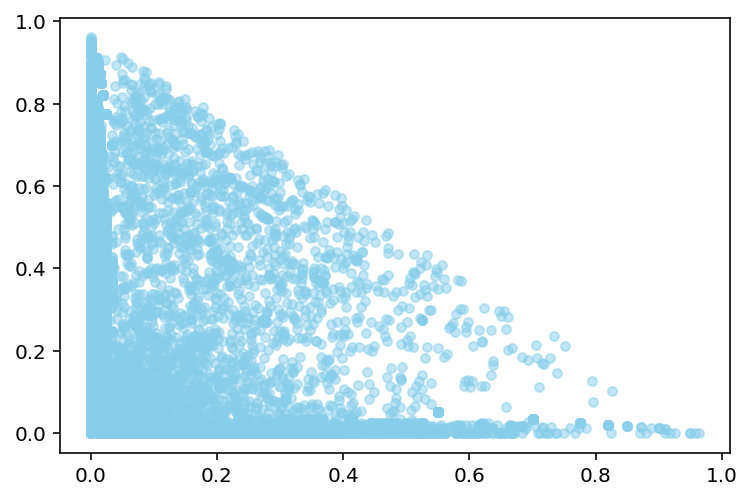

In [418]:
display_cluster(doc_topic)

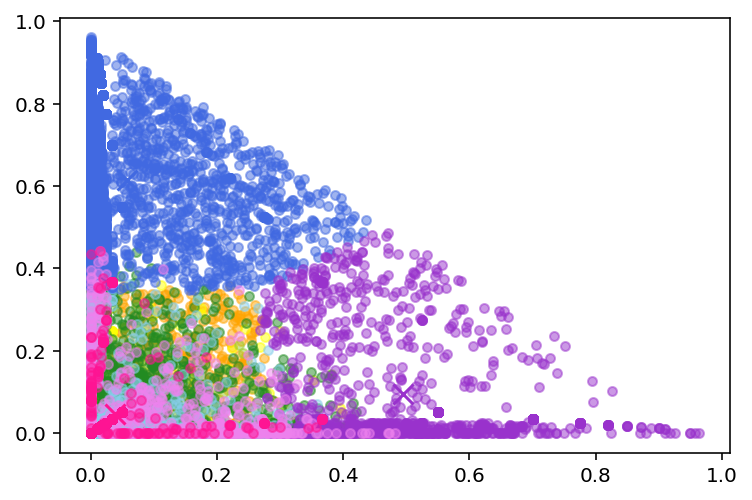

In [423]:
from sklearn.cluster import KMeans

num_clusters = 10 # my original number of topics 
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [384]:
km.inertia_

1921.1057861349004

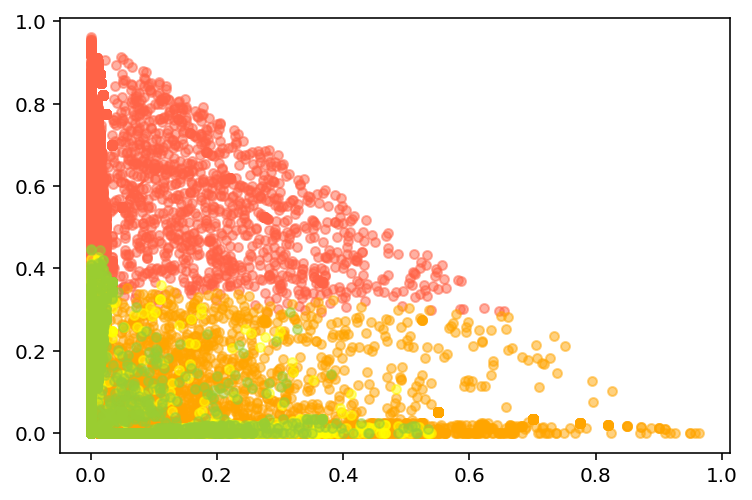

In [424]:
num_clusters = 4 # a randomly chosen smaller number of topics based on the image above
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [386]:
km.inertia_

4696.4146101820725

### Plotting Inertia
Plotting various inertias to see the idea number of clusters and hence topics for my data. 

In [387]:
import matplotlib.pyplot as plt

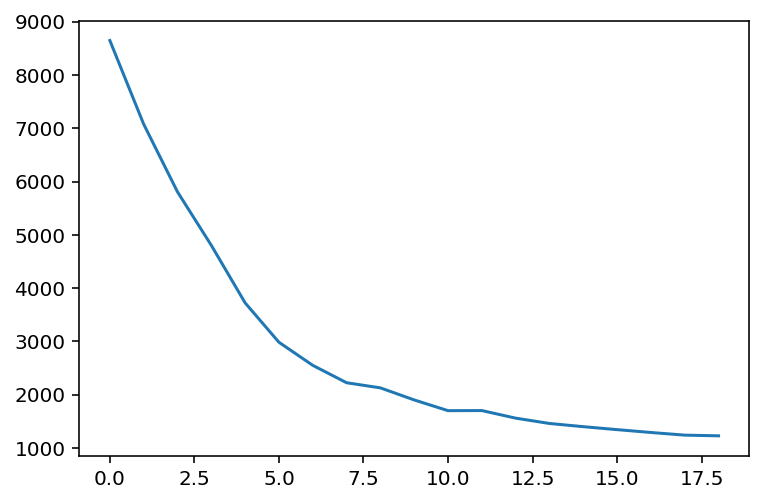

In [388]:
inertias = []
for i in range(1, 20):
    km = KMeans(n_clusters=i)
    km.fit(doc_topic)
    inertia = km.inertia_
    inertias.append(inertia)

plt.plot(inertias)
plt.show()

Alas, selbow at about 7 and 10. I already had 10 topics, but let's try 7 as well. Both pyLDAvis topic visualizations for 10 and 7 can be see in the pyLDAvis section above (and also 9 because I just tried that randomly). 

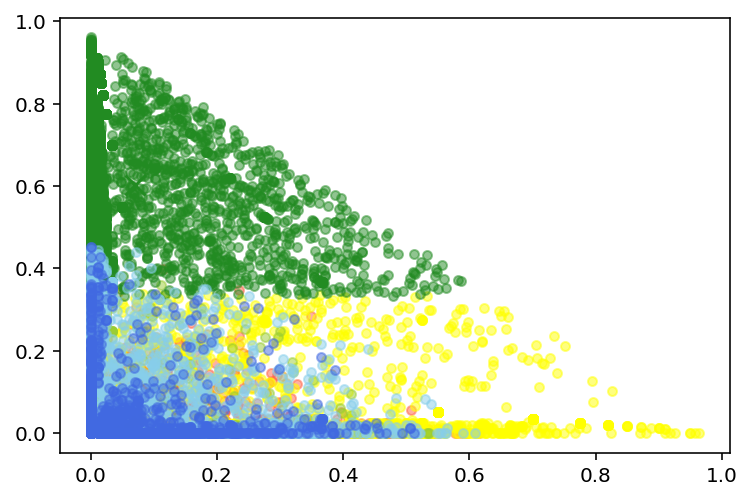

In [427]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [391]:
km.inertia_

2551.953800597193

# Dimensionality Reduction & Visualization
Now! The grande finale! Visualization! 

My goal in these visualizations is to see how similar or different the different *type* of documents (genres being Hinduism, Buddhism, Taosism, and Quantum Mechanics). Right now, the doc_topic matrix has a vector for each document of how much it falls into each topic. I am going to use PCA and t-SNE to reduce the doc_topic matrix's dimensions from 10 topics to 2-D space for plotting, then plot the space between all the documents. The colorization of types will then demonstrate how similar the genres are based on their topic vectors! 

## PCA <a class="anchor" id="pca"></a>

In [404]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(doc_topic)
pcafeatures = pca.transform(doc_topic)

In [407]:
df["Genre"]

0        Hinduism
1        Hinduism
2        Hinduism
3        Hinduism
4        Hinduism
           ...   
44969    Hinduism
44970    Hinduism
44971    Hinduism
44972    Hinduism
44973    Hinduism
Name: Genre, Length: 44974, dtype: object

In [408]:
target = df["Genre"]

In [480]:
target_names = list(target.unique())

In [409]:
print(doc_topic.shape)
print(pcafeatures.shape)

(44974, 10)
(44974, 2)


In [429]:
print(len(pcafeatures))
print(len(target))

44974
44974


In [647]:
def plot_PCA(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    plt.figure(figsize=(10,10))
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1],
                   c=c, label=label, alpha=0.4, s=10)
    plt.legend()

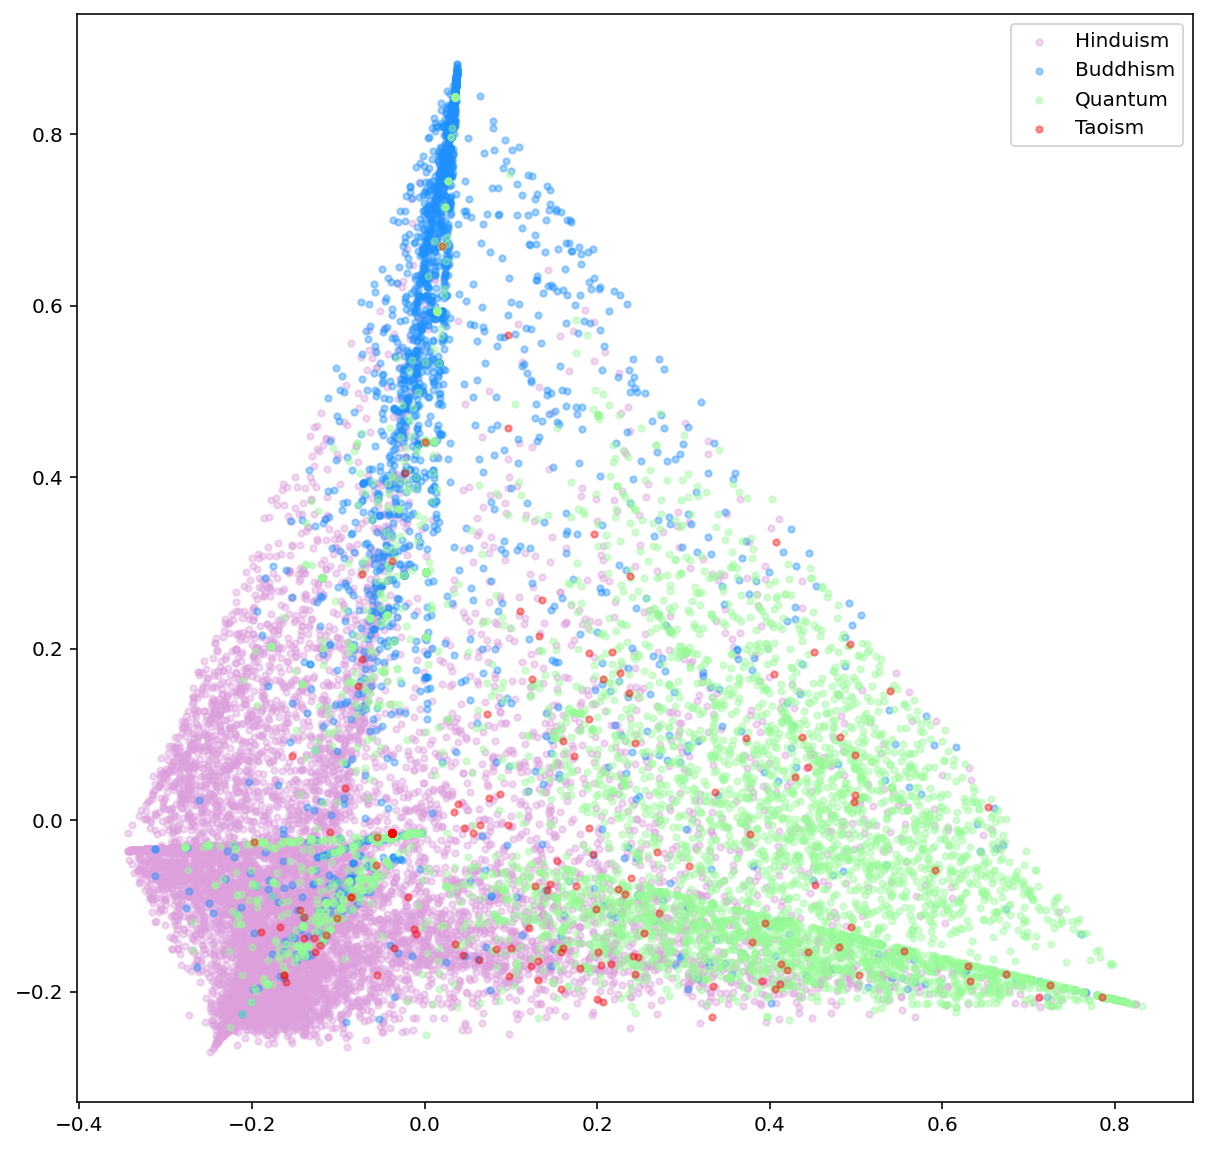

In [648]:
plot_PCA(pcafeatures, target=target, target_names=target_names)

## t-SNE <a class="anchor" id="tsne"></a>

In [523]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(doc_topic)

In [649]:
def plot_tsne(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    for c, label in zip(colors, target_names):
        plt.scatter(low_data[target == label, 0], low_data[target == label, 1], c=c, label=label, s=0.4, alpha=0.5)
    plt.legend(fontsize=6, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
    plt.xlim(-100,100);


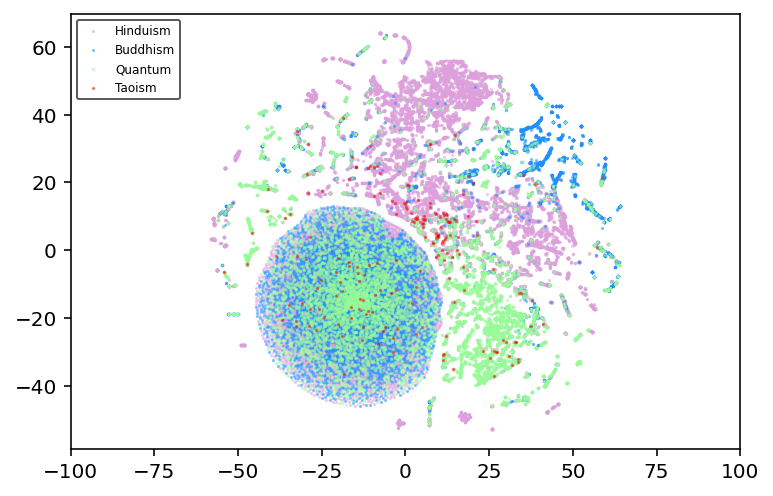

In [650]:
plot_tsne(tsne_data, target, target_names)

Tried re-running the above with a few different perplexities and it made no difference. 

## EDA-style <a class="anchor" id="eda"></a>
Also visualizing with simple aggregation! 


In [532]:
matrix = pd.concat([target, doc_topic_matrix], axis=1)

In [533]:
matrix

,Genre,0,1,2,3,4,5,6,7,8,9
0,Hinduism,0.775,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
1,Hinduism,0.504,0.363,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017
2,Hinduism,0.033,0.700,0.033,0.033,0.033,0.033,0.033,0.033,0.033,0.033
3,Hinduism,0.171,0.000,0.047,0.000,0.000,0.114,0.404,0.000,0.245,0.000
4,Hinduism,0.020,0.020,0.020,0.020,0.020,0.020,0.593,0.020,0.247,0.020
...,...,...,...,...,...,...,...,...,...,...,...
44969,Hinduism,0.000,0.192,0.000,0.000,0.000,0.672,0.000,0.104,0.000,0.000
44970,Hinduism,0.013,0.013,0.013,0.013,0.013,0.887,0.013,0.013,0.013,0.013
44971,Hinduism,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.775,0.025
44972,Hinduism,0.000,0.193,0.000,0.000,0.217,0.353,0.000,0.000,0.218,0.000


In [539]:
pd.value_counts(df["Genre"])

Hinduism    24003
Quantum     11003
Buddhism     9776
Taoism        192
Name: Genre, dtype: int64

In [549]:
counts = list(pd.value_counts(df["Genre"]))
counts

[24003, 11003, 9776, 192]

In [535]:
matrix = matrix.groupby("Genre").sum()

In [536]:
matrix

,0,1,2,3,4,5,6,7,8,9
Genre,,,,,,,,,,
Buddhism,807.470,775.930,679.587,826.590,753.064,861.974,843.587,722.756,2495.544,959.187
Hinduism,2062.291,3604.591,2034.358,1392.175,3282.575,2074.720,3532.860,2730.256,1912.104,1146.166
Quantum,649.309,831.807,533.349,729.333,745.278,3425.216,862.226,673.781,1243.766,1227.659
Taoism,9.105,12.617,6.865,10.288,12.729,48.285,48.695,8.944,24.180,7.731


In [552]:
matrix.iloc[0] = matrix.iloc[0]/counts[2]
matrix.iloc[1] = matrix.iloc[1]/counts[0]
matrix.iloc[2] = matrix.iloc[2]/counts[1]
matrix.iloc[3] = matrix.iloc[3]/counts[3]

In [560]:
matrix.reset_index(inplace=True)
matrix

,Genre,0,1,2,3,4,5,6,7,8,9
0,Buddhism,0.083,0.079,0.070,0.085,0.077,0.088,0.086,0.074,0.255,0.098
1,Hinduism,0.086,0.150,0.085,0.058,0.137,0.086,0.147,0.114,0.080,0.048
2,Quantum,0.059,0.076,0.048,0.066,0.068,0.311,0.078,0.061,0.113,0.112
3,Taoism,0.047,0.066,0.036,0.054,0.066,0.251,0.254,0.047,0.126,0.040


In [558]:
for i, topic in enumerate(all_topic_words): 
    print("Topic {}: {} \n".format(i, ", ".join(topic)))

Topic 0: body, fire, mind, water, breath, earth, stream, within, eye, head, heart, voice, name, sun, speech, form, side, wild, vital, sound, slayer, taste, cry, air, force, light, take, heat, sight, together 

Topic 1: man, spiritual man, soul, cause, world, yonder, self, one, life, death, free, press, disease, body, pain, work, sleep, go, instance, stand, sect, must, state, word, hence, sin, form, rapid, thing, whether 

Topic 2: indra, strength, praise, varuna, rig, mitra, song, hero, world heaven, grant, protect, mitra varuna, drink soma, bay, harm, protection, soma juice, thunderbolt, laud, varuna mitra, conquer, liberal, hear, love, evermore, draught, giver, wealthy, together, bounty 

Topic 3: path, good, people, bestow, onward, lead, horse, evil, us, overcome, noble, charm, die, brilliant, realm, right, along, way, guide, top, choice, trouble, see, take, song, success, gravity, one, saman, high 

Topic 4: man, art, heaven, wealth, god, bring, mighty, give, forth, lord, power, st

In [669]:
import seaborn as sns

def plot_topic_distribution(row, genre, color):
    plt.figure(figsize=(4, 3))
    sns.barplot(x=matrix.columns[1:], y=matrix.iloc[row, 1:], palette=color)
    plt.show()
    #plt2.xlabel("Topic")
    #plt2.title("Topic Distribution of " + genre)
    # I get an error saying matplotlib.pyplot has no attribute title, due to a dumb error from earlier where I used incorrect syntax plt.title = "something", then realized that was wrong syntax, but plt.title had been assigned as a string, then I deleted it, now it doens't exist. I'd need to restart my kernel to get functionality back but I'm not willing to lose ALL my variables so... nah. 

Buddhism


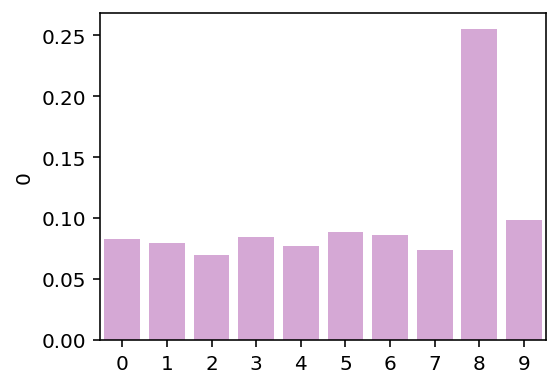



Hinduism


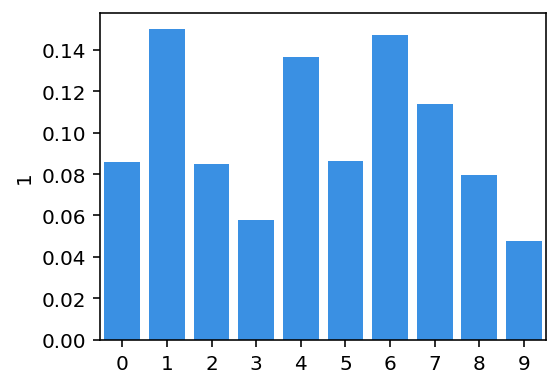



Quantum


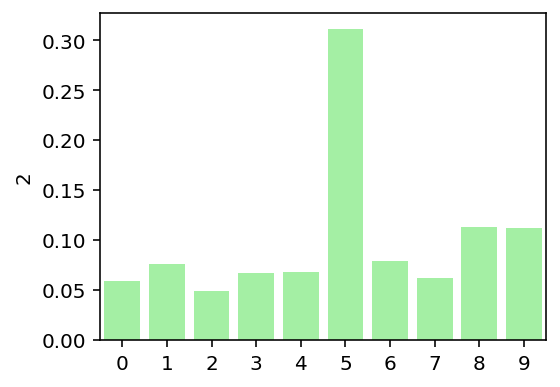



Taoism


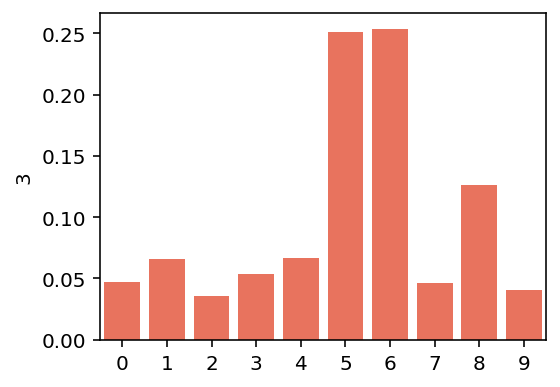

In [670]:
colors = ['plum','dodgerblue', 'palegreen','tomato']
for i, genre in enumerate(matrix["Genre"]):
    print(genre)
    plot_topic_distribution(i, genre, [colors[i]])
    print("\n")

# Takeaways <a class="anchor" id="conc"></a>

The key takeaway here is that there is a great deal of similarity in all of the texts! 

While there are of course some terms and topics specific to each field, the vast majority of the discussion concerning consciousness and reality is shared across documents. 

Beyond that, the content of the shared topics words leans heavily toward monistic idealism, as does Eastern Thought on consciousness and reality itself. 

## Implications

What this seems to demonstrate is that descriptions of consciousness in quantum and in eastern philosophy are remarkably similar, and hence that quantum physics could open a door to deeper understanding of implicate non-physical realms. Or rather, we could integrate the teachings of Eastern Philosophy, if so heavily correlated, into further quantum physics/quantum computing/AI research, which could potentially lead to breakthroughs! 



## Bonus Content: 

Thanks for reading all the way to the end here's an easter egg!

## CorEx with Anchoring <a class="anchor" id="corex"></a>

(PLEASE NOTE: This section of CorEx exploration was carried out before the LDA optimization and visualization seen above. It seemed promising since its semi-supervised nature allowed me to anchor to themes of consciousness, and it did indeed let me see how the same term/concept was discussed in different ways! ...but the topics turned out very similar and hence not very separable, and deciding on the perfect combination of anchor words would be tough. Ultimately adding min_df and careful tuning of the LDA model yielded better results. And, more insightful results! Since it was truly unsupervised -- allowed me to actually conceptualize the similarity between my topics and my various types of documents. I am still including the CorEx model exploration, however, below.)

I'm now going to try the CorEx model with various anchors. Since the information I most care about in these documents is that which pertains to concsciousness and self, and not every document (paragraph) will contain those things, it helps to anchor. 

Specifically, I am interested in the nuance of how those same terms are used in different contexts within and between documents which CorEx is well suited to. For this reason, the control that the new and semi-supervised model CorEx provides me with is ideal. 

After the 5th iteration, I changed the function to also print the topic correlation (TC) for the model.  

In [276]:
corex(doc_word, feature_names, 10)

0: oh,even world,middle end,peerless,rich bear,girdle,food one,brahman art,sustainable,dear boy father
1: hundred time,tari ness,tari,man tari,man tari ness,mo man tari,unit joy,one unit joy,one unit,beginning one
2: man,one,earth,make,heaven,sacrifice,indra,lord,forth,go
3: appropriate,common indicate,attribution noncommercial international,attribution noncommercial,reproduction medium,reproduction medium format,commons attribution noncommercial,commons attribution,indicate make,distribution reproduction
4: vidya,bank,away every,give fortune,give fortune fail,enter avenue,wealthy cow,fortune fail loud,return boon,fail loud speak
5: ascetic,mendicant,mendicant monk,householder,good hero,bare,tuft,due order,deaf,clean
6: nature,consciousness,mind,knowledge,know,world,see,brahman,time,become
7: peace peace,om peace,om peace peace,environment peace,environment peace act,peace environment peace,peace environment,peace act,peace peace environment,peace
8: kind,evermore,pleasant,noble,approa

In [15]:
def corex(doc_word, feature_names, num_topics, anchors, anchor_strength):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data, anchors=anchors, anchor_strength=anchor_strength)

    topics = model.get_topics(n_words=20)
    print("TC: ", model.tc)
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

First, getting a feel for how CorEx interprets topics unsupervised (no anchors) -- generating 50 topics to get a wide spread / in depth look.

In [17]:
doc_word, feature_names, id2word = vectorize(data, "cv", True)

In [291]:
corex(doc_word, feature_names, 50, None, None)

TC:  111.35523355792589
0: infinite,infinite brahman,proceed,infinite infinite,brahman alone,remain infinite,infinite brahman alone,universe infinite infinite,infinite universe infinite,infinite universe remain,brahman infinite universe,om brahman infinite,proceed infinite,infinite infinite proceed,infinitude infinite universe,infinitude infinite,universe remain infinite,universe infinite,proceed infinite take,infinite take
1: assembly,herald,rapturous,gloom,guerdon,herd,exhaustless,rapturous joy,loud speak,thirsty,cheerful,strength man,unclose,spell,speak assembly,sacrifice priest,drain,loud speak assembly,bl,flow juice
2: freely,constitute body,veil,conformity,access conformity,convention,preparation access conformity,preparation access,unreasonable,great detail,whose mind,mind man,contact feel,da man,fun da man,fun da,bury,fun,sakha,world ever
3: hail hail,hail hail hail,earth hail,upright,make wealth,sacrificer two,whose hand,sun see,car bring,atmosphere hail,sky great,piler,often 

Now anchoring to various relevant terms using domain knowledge.

The next many iterations are just trying out different terms and combinations of terms to see what is prevalent. 

In [278]:
corex(doc_word, feature_names, 10, [["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"]], 2)

0: consciousness,five,nose,imagination,mendicant monk,latent,unclad,nonexistence,object consciousness,consciousness consciousness
1: consciousness,smell,fruition,investigate,registration,chit,rid,eternally,object object,succession
2: one,make,sacrifice,heaven,earth,indra,strength,forth,wealth,art
3: consciousness,due,pure consciousness,dreamless,cease,dreamless sleep,samadhi,prajna,blissful,good bad
4: consciousness,attribute,brahman self,indestructible,attach,knowledge infinite,anything else,quiescent,monk,true knowledge infinite
5: man,self,cause,soul,brahman,text,body,state,hence,un
6: es,lar,sim,pur,tab,sim lar,es tab,tic,mor,pose
7: nature,quantum,see,knowledge,mind,theory,time,however,reality,different
8: om peace,om peace peace,peace peace,environment peace,environment peace act,peace environment peace,peace environment,peace act,peace,peace peace environment
9: oxford university,university,university press,press,oxford,oxford university press,volume,theosophical house,theosophi

In [280]:
corex(doc_word, feature_names, 10, [["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"]], 2)

0: consciousness,emblematic,existence nonexistence,loincloth,real unreal,ritual,deep meditation,emblematic staff,one state,adharma
1: consciousness,monk,mendicant monk,brahman alone,anything else,communicate,good bad,anything great,tranquillity,declaration
2: one,sacrifice,make,indra,heaven,earth,strength,forth,wealth,art
3: consciousness,pure consciousness,dreamless,dreamless sleep,staff,death consciousness,consciousness one,self high,prajna,self high self
4: consciousness,essential nature,agent,whose nature,brahman whose,unclad,restraint,self free,quiescent,know subject
5: consciousness,purport,nonexistence,whole universe,brahman without,effect cause,unevolved,footnote,goodness,accord mind
6: consciousness,know,mind,nature,see,knowledge,world,time,different,object
7: man,cause,un,fore,ment,fi,soul,dis,er,ta
8: consciousness,chit,state state,great lord,spiritual wisdom,stainless,partless,brahman something,implicate,bliss nature
9: consciousness,consciousness consciousness,rebirth cons

In [282]:
corex(doc_word, feature_names, 10, [["self"], ["self"], ["self"], ["self"], ["self"], ["self"], ["self"], ["self"], ["self"], ["self"]], 2)

0: self,everything else,unclad,brahman far,pure intelligence,perishable,tuft,nonexistence,pride,ritual
1: self,mendicant,worldly life,ascetic,mendicant monk,pure consciousness,monk,god brahma,anything great,brahman revere
2: one,sacrifice,indra,heaven,make,strength,earth,wealth,mighty,art
3: self,grief,age death,old age death,tranquil,free sin,one hundred,indeed know,none high,without eat
4: self,posture,emblematic staff,deaf,middle end,nostril,bar,fire water water,bar ley,ley
5: self,high self,self self,individual self,atman,brahman self,know self,self brahman,self one,supreme self
6: self,man,cause,soul,brahman,body,state,text,hence,form
7: self,consciousness,nature,know,mind,knowledge,see,time,world,become
8: self,intelligent nonintelligent,beginning one,next world,one high,upon om,beginning one without,nonintelligent matter,mean set,really one
9: self,belong,plurality,object meditation,thereupon,body high,antagonistic,know subject,caste,whole universe


In [283]:
corex(doc_word, feature_names, 10, [["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"], ["conscious"]], 2)

0: conscious,alm,unclad,staff,ritual fire,loincloth,emblematic,mind vital,superimpose,semen
1: conscious,mendicant,passion,beneficial,exalted,householder,hamsa,supremely,ritual,renounce
2: man,one,self,know,world,go,even,cause,body,high
3: consciousness,object,knowledge,different,sense,conscious,individual,existence,mental,person
4: infinite,essential nature,proceed,conscious,infinite brahman,brahman alone,oneness,one brahman,infinitude,brahman infinite
5: conscious,yogin,indestructible,supreme bliss,speech one,object knowledge,unevolved,anything else,become brahman,chit
6: indra,sacrifice,heaven,strength,wealth,earth,make,mighty,soma,art
7: quantum,theory,reality,nature,human,physics,physical,brain,universe,conscious
8: conscious,wake state,self far,person whose,know knower,gaining,self hand,pass beyond,mentality,untrue
9: conscious,fighting,praise song,unmanifest,holy worship,mighty god,dragon deep,car bring,body bear,speak truth


In [310]:
corex(doc_word, feature_names, 5, [["individual"], ["individual"], ["individual"], ["individual"], ["individual"]], 2)

TC:  69.85939602637633
0: individual,ruler,ally,staff,alm,yearn,devoted,something great,one place,crown,anything great,free act,fold,free act sphere,sphere within reach,act sphere within,act sphere,sphere within,sir anything great,sir anything
1: individual,individual soul,soul,individual self,clause,denote,account,aim,agreement,self brahman,ascetic,incapable,maya,inner self,self individual,object meditation,mu,plurality,indestructible,declaration
2: one,know,world,become,see,mind,individual,time,two,brahman,life,even,knowledge,nature,self,without,way,body,many,form
3: indra,sacrifice,heaven,strength,man,wealth,make,earth,mighty,soma,bring,art,forth,rich,lord,bear,give,strong,food,great
4: individual,cause,high brahman,high self,scripture,ether,atman,essential nature,nescience,scriptural,nonsentient,set forth,unreal,owe,agent,knower,one brahman,brahman self,mantra,jiva


In [312]:
corex(doc_word, feature_names, 10, [["consciousness", "consciousness", "consciousness", "consciousness", "consciousness", "self", "self", "self", "self", "self"]], 2)

TC:  80.50404814845143
0: one,self,make,consciousness,earth,know,heaven,sacrifice,great,give,even,forth,become,strength,god,wealth,go,bear,world,bring
1: infinite infinite,infinite universe,remain infinite brahman,proceed infinite take,proceed infinite,take infinitude infinite,take infinitude,infinite brahman alone,universe remain infinite,universe infinite infinite,universe infinite,infinite infinite proceed,infinite proceed,infinite proceed infinite,infinitude infinite universe,infinitude infinite,infinite take,infinite take infinitude,infinite universe remain,om brahman infinite
2: man,cause,soul,text,hence,ment,state,fore,son,dis,sruti,ta,scrip,thing,edge,sub,pro,ar,word,case
3: eightfold,noble eightfold,noble eightfold path,eightfold path,bear sacrifice,conscious bliss,grow mighty,breath one,right action,town,hare,lucky,mixed,right speech,essential character,five earth,free fear,atman atman know,eat food dear,eat food see
4: quantum,theory,reality,physics,physical,information,brai

In [321]:
corex(doc_word, feature_names, 6, [["consciousness", "one"], ["consciousness", "two"], ["consciousness", "different"], ["reality"], ["consciousness", "mind"], ["consciousness", "nature"]], 2)

TC:  73.16587985413169
0: one,sacrifice,man,heaven,make,indra,earth,strength,wealth,forth,art,mighty,bring,lord,god,great,bear,soma,food,go
1: two,consciousness,arise,five,six,eight,rebirth,occur,associate,class,two one,root,wholesome,visible,immaterial,plane,registration,two two,one two,unwholesome
2: different,consciousness,self,brahman,time,knowledge,see,state,without,form,way,individual,person,hence,text,object,view,take,true,sense
3: reality,quantum,theory,al,cause,physics,ment,information,brain,physical,fore,dis,human,universe,fundamental,could,mechanic,mathematical,science,pro
4: mind,consciousness,human mind,mind mind,yoga,ear,intellect,prana,organ,concentration,speech mind,door,delusion,one mind,feel,control,mana,smell,ego,mind one
5: nature,consciousness,essential,essential nature,true nature,spiritual,attribute,depend,function,nature brahman,understanding,essentially,manifest,false,nature self,pure consciousness,vision,oppose,intuition,create


In [18]:
corex(doc_word, feature_names, 10, [["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["consciousness"], ["self"], ["self"], ["self"], ["self"], ["self"]], 2)

TC:  83.54408557312918
0: consciousness,five,arise,wholesome,rebirth,unwholesome,occur,immaterial,plane,six,root,eight,registration,door,sphere,supramundane,fruition,attainment,sensuous,greed
1: consciousness,consciousness consciousness,pure consciousness,object consciousness,consciousness object,consciousness arise,consciousness one,universal consciousness,type consciousness,consciousness investigate,consciousness mind,journal consciousness,consciousness exploration,exploration research,consciousness exploration research,hard problem,exploration,eye consciousness,journal consciousness exploration,problem consciousness
2: indra,sacrifice,heaven,strength,make,wealth,earth,mighty,art,soma,bring,forth,rich,food,lord,bear,great,give,god,holy
3: consciousness,nature,see,time,quantum,knowledge,mind,different,however,theory,reality,physical,human,object,sense,understand,effect,matter,existence,universe
4: consciousness,neutral,protect speaker,speaker protect,speaker protect speaker,protect sp

In [19]:
corex(doc_word, feature_names, 2, [["cognition"], ["cognition"]], 2) 

TC:  44.71375770617515
0: self,know,world,mind,nature,see,brahman,state,knowledge,time,cognition,body,different,without,way,two,consciousness,person,sense,must
1: one,man,make,earth,heaven,sacrifice,wealth,give,lord,god,forth,indra,strength,go,great,even,bring,bear,rich,good
